In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
         .master("local[4]") \
        .config("spark.executor.memory", "2g") \
        .config("spark.driver.memory", "8g") \
        .config("spark.memory.offHeap.enabled",True) \
        .config("spark.memory.offHeap.size","2g") \
        .config("spark.python.worker.memory","1g") \
        .appName('PGA').getOrCreate()
# spark=SparkSession.builder.appName('PGA').getOrCreate()

In [3]:
from pyspark.sql.functions import*
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import col,sum
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from pyspark.mllib.util import*
from pyspark.ml.feature import*
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.conf import SparkConf
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA

In [8]:
####Importing data
events_df=spark.read.csv('/home/jovyan/work/PGA/event/Event2*/PGATour/Exports/*.TXT',header=True, sep=';',inferSchema=True
)
hole_df=spark.read.csv('/home/jovyan/work/PGA/hole/Hole*/PGATour/Exports/*.TXT',header=True, sep=';',inferSchema=True)
round_df=spark.read.csv('/home/jovyan/work/PGA/round/Round*/PGATour/Exports/*.TXT',header=True, sep=';',inferSchema=True)
shot_df=spark.read.csv('/home/jovyan/work/PGA/shot/Shot*/PGATour/Exports/*.TXT',header=True, sep=';',inferSchema=True)

In [6]:
############## Dataframe's shape

In [40]:
print((events_df.count(), len(events_df.columns)))

(89560, 201)


In [7]:
print((round_df.count(), len(round_df.columns)))

(277190, 179)


In [8]:
print((hole_df.count(), len(hole_df.columns)))

(4960634, 56)


In [9]:
print((shot_df.count(), len(shot_df.columns)))

(16195605, 43)


In [9]:
# strip spaces from column names(event)
new_column_name_event= list(map(lambda x: x.strip().replace('.',''), events_df.columns))

events_df = events_df.toDF(*new_column_name_event)

In [10]:
# strip spaces from column names(event)
new_column_name_round= list(map(lambda x: x.strip().replace('.',''), round_df.columns))

round_df = round_df.toDF(*new_column_name_round)

In [11]:
round_df= round_df.withColumnRenamed("Tournament #", "Tournament Number")

In [10]:
#Round_1_2_df.select('Event Name').distinct().show(20,False)

In [11]:
######as we need only round 1 and 2 for predicting the tournament outcome ,we used the round table to create some new features for model

In [12]:
from pyspark.sql.functions import col, when, lit
new_df = round_df.withColumn("Round 1 Course Yardage",when(col("Round Number") == 1, col("Course Yardage")).otherwise(lit(None))) \
                     .withColumn("Round 2 Course Yardage",when(col("Round Number") == 2, col("Course Yardage")).otherwise(lit(None))) \
                     .withColumn("Round 1 Eagles",when(col("Round Number") == 1, col("Eagles")).otherwise(lit(None))) \
                     .withColumn("Round 2 Eagles",when(col("Round Number") == 2, col("Eagles")).otherwise(lit(None))) \
                     .withColumn("Round 1 Birdies",when(col("Round Number") == 1, col("Birdies")).otherwise(lit(None))) \
                     .withColumn("Round 2 Birdies",when(col("Round Number") == 2, col("Birdies")).otherwise(lit(None))) \
                     .withColumn("Round 1 Pars",when(col("Round Number") == 1, col("Pars")).otherwise(lit(None))) \
                     .withColumn("Round 2 Pars",when(col("Round Number") == 2, col("Pars")).otherwise(lit(None))) \
                     .withColumn("Round 1 Bogeys",when(col("Round Number") == 1, col("Bogeys")).otherwise(lit(None))) \
                     .withColumn("Round 2 Bogeys",when(col("Round Number") == 2, col("Bogeys")).otherwise(lit(None))) \
                     .withColumn("Round 1 Doubles",when(col("Round Number") == 1, col("Doubles")).otherwise(lit(None))) \
                     .withColumn("Round 2 Doubles",when(col("Round Number") == 2, col("Doubles")).otherwise(lit(None))) \
                     .withColumn("Round 1 Total Holes Over Par",when(col("Round Number") == 1, col("Total Holes Over Par")).otherwise(lit(None))) \
                     .withColumn("Round 2 Total Holes Over Par",when(col("Round Number") == 2, col("Total Holes Over Par")).otherwise(lit(None))) \
                     .withColumn("Round 1 Longest Drive",when(col("Round Number") == 1, col("Longest Drive")).otherwise(lit(None))) \
                     .withColumn("Round 2 Longest Drive",when(col("Round Number") == 2, col("Longest Drive")).otherwise(lit(None))) \
                     .withColumn("Round 1 Driving Distance(Total Distance)",when(col("Round Number") == 1, col("Driving Distance(Total Distance)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Driving Distance(Total Distance)",when(col("Round Number") == 2, col("Driving Distance(Total Distance)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Driving Dist - All Drives(Tot Dist)",when(col("Round Number") == 1, col("Driving Dist - All Drives(Tot Dist)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Driving Dist - All Drives(Tot Dist)",when(col("Round Number") == 2, col("Driving Dist - All Drives(Tot Dist)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Total Greens in Regulation",when(col("Round Number") == 1, col("Total Greens in Regulation")).otherwise(lit(None))) \
                     .withColumn("Round 2 Total Greens in Regulation",when(col("Round Number") == 2, col("Total Greens in Regulation")).otherwise(lit(None))) \
                     .withColumn("Round 1 GIR Rank",when(col("Round Number") == 1, col("GIR Rank")).otherwise(lit(None))) \
                     .withColumn("Round 2 GIR Rank",when(col("Round Number") == 2, col("GIR Rank")).otherwise(lit(None))) \
                     .withColumn("Round 1 Total Distance(ft) Prox to Hole",when(col("Round Number") == 1, col("Total Distance(ft) Prox to Hole")).otherwise(lit(None))) \
                     .withColumn("Round 2 Total Distance(ft) Prox to Hole",when(col("Round Number") == 2, col("Total Distance(ft) Prox to Hole")).otherwise(lit(None))) \
                     .withColumn("Round 1 Rough Prox(distance in ft)",when(col("Round Number") == 1, col("Rough Prox(distance in ft)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Rough Prox(distance in ft)",when(col("Round Number") == 2, col("Rough Prox(distance in ft)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Fairway Prox(distance in ft)",when(col("Round Number") == 1, col("Fairway Prox(distance in ft)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Fairway Prox(distance in ft)",when(col("Round Number") == 2, col("Fairway Prox(distance in ft)")).otherwise(lit(None))) \
                     .withColumn("Round 1 # of Attempts Prox to Hole",when(col("Round Number") == 1, col("# of Attempts Prox to Hole")).otherwise(lit(None))) \
                     .withColumn("Round 2 # of Attempts Prox to Hole",when(col("Round Number") == 2, col("# of Attempts Prox to Hole")).otherwise(lit(None))) \
                     .withColumn("Round 1 Scrambling Proximity (Total Distance)",when(col("Round Number") == 1, col("Scrambling Proximity (Total Distance)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Scrambling Proximity (Total Distance)",when(col("Round Number") == 2, col("Scrambling Proximity (Total Distance)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Scrambling Proximity (# of shots)",when(col("Round Number") == 1, col("Scrambling Proximity (# of shots)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Scrambling Proximity (# of shots)",when(col("Round Number") == 2, col("Scrambling Proximity (# of shots)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Sand Save %(# Saves)",when(col("Round Number") == 1, col("Sand Save %(# Saves)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Sand Save %(# Saves)",when(col("Round Number") == 2, col("Sand Save %(# Saves)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Sand Save %(# Bunkers)",when(col("Round Number") == 1, col("Sand Save %(# Bunkers)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Sand Save %(# Bunkers)",when(col("Round Number") == 2, col("Sand Save %(# Bunkers)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Total Hole Outs",when(col("Round Number") == 1, col("Total Hole Outs")).otherwise(lit(None))) \
                     .withColumn("Round 2 Total Hole Outs",when(col("Round Number") == 2, col("Total Hole Outs")).otherwise(lit(None))) \
                    .withColumn("Round 1 Overall Putting Avg(# of Putts)",when(col("Round Number") == 1, col("Overall Putting Avg(# of Putts)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Overall Putting Avg(# of Putts)",when(col("Round Number") == 2, col("Overall Putting Avg(# of Putts)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Putting Avg(GIR Putts)",when(col("Round Number") == 1, col("Putting Avg(GIR Putts)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Putting Avg(GIR Putts)",when(col("Round Number") == 2, col("Putting Avg(GIR Putts)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Avg Distance of Putts Made(Total Distance of Putts)",when(col("Round Number") == 1, col("Avg Distance of Putts Made(Total Distance of Putts)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Avg Distance of Putts Made(Total Distance of Putts)",when(col("Round Number") == 2, col("Avg Distance of Putts Made(Total Distance of Putts)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Putting 5' - 10' (putts made)",when(col("Round Number") == 1, col("Putting 5' - 10' (putts made)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Putting 5' - 10' (putts made)",when(col("Round Number") == 2, col("Putting 5' - 10' (putts made)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Putting 4'-8'(putts made)",when(col("Round Number") == 1, col("Putting 4'-8'(putts made)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Putting 4'-8'(putts made)",when(col("Round Number") == 2, col("Putting 4'-8'(putts made)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Putting   10'-15'(putts made)",when(col("Round Number") == 1, col("Putting   10'-15'(putts made)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Putting   10'-15'(putts made)",when(col("Round Number") == 2, col("Putting   10'-15'(putts made)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Putting 15'-20'(putts made)",when(col("Round Number") == 1, col("Putting 15'-20'(putts made)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Putting 15'-20'(putts made)",when(col("Round Number") == 2, col("Putting 15'-20'(putts made)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Putting 20'-25'(putts made)",when(col("Round Number") == 1, col("Putting 20'-25'(putts made)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Putting 20'-25'(putts made)",when(col("Round Number") == 2, col("Putting 20'-25'(putts made)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Total Putts Gained",when(col("Round Number") == 1, col("Total Putts Gained")).otherwise(lit(None))) \
                     .withColumn("Round 2 Total Putts Gained",when(col("Round Number") == 2, col("Total Putts Gained")).otherwise(lit(None))) \
                     .withColumn("Round 1 Total SG T2G",when(col("Round Number") == 1, col("Total SG T2G")).otherwise(lit(None))) \
                     .withColumn("Round 2 Total SG T2G",when(col("Round Number") == 2, col("Total SG T2G")).otherwise(lit(None))) \
                    .withColumn("Round 1 Total SG Total",when(col("Round Number") == 1, col("Total SG Total")).otherwise(lit(None))) \
                     .withColumn("Round 2 Total SG Total",when(col("Round Number") == 2, col("Total SG Total")).otherwise(lit(None))) \
                     .withColumn("Round 1 OTT SG Avg",when(col("Round Number") == 1, col("OTT SG Avg")).otherwise(lit(None))) \
                     .withColumn("Round 2 OTT SG Avg",when(col("Round Number") == 2, col("OTT SG Avg")).otherwise(lit(None))) \
                     .withColumn("Round 1 APP SG Avg",when(col("Round Number") == 1, col("APP SG Avg")).otherwise(lit(None))) \
                     .withColumn("Round 2 APP SG Avg",when(col("Round Number") == 2, col("APP SG Avg")).otherwise(lit(None))) \
                     .withColumn("Round 1 ARG SG Avg",when(col("Round Number") == 1, col("ARG SG Avg")).otherwise(lit(None))) \
                     .withColumn("Round 2 ARG SG Avg",when(col("Round Number") == 2, col("ARG SG Avg")).otherwise(lit(None))) \
                     .withColumn("Round 1 Avg Distance of Putts Made(Total Distance of Putts)",when(col("Round Number") == 1, col("Avg Distance of Putts Made(Total Distance of Putts)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Avg Distance of Putts Made(Total Distance of Putts)",when(col("Round Number") == 2, col("Avg Distance of Putts Made(Total Distance of Putts)")).otherwise(lit(None))) \
                     .withColumn("Round 1 3-Putt Avoid(Total 3 Putts)",when(col("Round Number") == 1, col("3-Putt Avoid(Total 3 Putts)")).otherwise(lit(None))) \
                     .withColumn("Round 2 3-Putt Avoid(Total 3 Putts)",when(col("Round Number") == 2, col("3-Putt Avoid(Total 3 Putts)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Scrambling Missed GIR",when(col("Round Number") == 1, col("Scrambling Missed GIR")).otherwise(lit(None))) \
                     .withColumn("Round 2 Scrambling Missed GIR",when(col("Round Number") == 2, col("Scrambling Missed GIR")).otherwise(lit(None))) \
                     .withColumn("Round 1 Scrambling from the Fringe(successes)",when(col("Round Number") == 1, col("Scrambling from the Fringe(successes)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Scrambling from the Fringe(successes)",when(col("Round Number") == 2, col("Scrambling from the Fringe(successes)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Approaches 50-125 Yards(ft)",when(col("Round Number") == 1, col("Approaches 50-125 Yards(ft)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Approaches 50-125 Yards(ft)",when(col("Round Number") == 2, col("Approaches 50-125 Yards(ft)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Approaches 125-150 Yards(ft)",when(col("Round Number") == 1, col("Approaches 125-150 Yards(ft)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Approaches 125-150 Yards(ft)",when(col("Round Number") == 2, col("Approaches 125-150 Yards(ft)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Approaches 150-175 Yards(ft)",when(col("Round Number") == 1, col("Approaches 150-175 Yards(ft)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Approaches 150-175 Yards(ft)",when(col("Round Number") == 2, col("Approaches 150-175 Yards(ft)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Approaches 175-200 Yards(ft)",when(col("Round Number") == 1, col("Approaches 175-200 Yards(ft)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Approaches 175-200 Yards(ft)",when(col("Round Number") == 2, col("Approaches 175-200 Yards(ft)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Approaches >200 Yards(ft)",when(col("Round Number") == 1, col("Approaches >200 Yards(ft)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Approaches >200 Yards(ft)",when(col("Round Number") == 2, col("Approaches >200 Yards(ft)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Driving Acc %(Fairways Hit)",when(col("Round Number") == 1, col("Driving Acc %(Fairways Hit)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Driving Acc %(Fairways Hit)",when(col("Round Number") == 2, col("Driving Acc %(Fairways Hit)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Driving Acc %(Possible Fairways)",when(col("Round Number") == 1, col("Driving Acc %(Possible Fairways)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Driving Acc %(Possible Fairways)",when(col("Round Number") == 2, col("Driving Acc %(Possible Fairways)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Scrambling from the Rough(successes)",when(col("Round Number") == 1, col("Scrambling from the Rough(successes)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Scrambling from the Rough(successes)",when(col("Round Number") == 2, col("Scrambling from the Rough(successes)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Going for the Green(successes)",when(col("Round Number") == 1, col("Going for the Green(successes)")).otherwise(lit(None))) \
                     .withColumn("Round 2 Going for the Green(successes)",when(col("Round Number") == 2, col("Going for the Green(successes)")).otherwise(lit(None))) \
                     .withColumn("Round 1 Total Holes Played",when(col("Round Number") == 1, col("Total Holes Played")).otherwise(lit(None))) \
                     .withColumn("Round 2 Total Holes Played",when(col("Round Number") == 2, col("Total Holes Played")).otherwise(lit(None))) 

In [13]:
new_df=new_df.filter(col('Round Number')<=2)

In [30]:
print((new_df.count(), len(new_df.columns)))

(176477, 275)


In [ ]:
#############Only keep the new features that we just created from round table

In [14]:
new_round_df=new_df.select(['Tournament Year','Tournament Number',  'Player Number', 'Player Name','Event Name','Round 1 Course Yardage',
 'Round 2 Course Yardage',
 'Round 1 Eagles',
 'Round 2 Eagles',
 'Round 1 Birdies',
 'Round 2 Birdies',
 'Round 1 Pars',
 'Round 2 Pars',
 'Round 1 Bogeys',
 'Round 2 Bogeys',
 'Round 1 Doubles',
 'Round 2 Doubles',
 'Round 1 Total Holes Over Par',
 'Round 2 Total Holes Over Par',
 'Round 1 Longest Drive',
 'Round 2 Longest Drive',
 'Round 1 Driving Distance(Total Distance)',
 'Round 2 Driving Distance(Total Distance)',
 'Round 1 Driving Dist - All Drives(Tot Dist)',
 'Round 2 Driving Dist - All Drives(Tot Dist)',
 'Round 1 Total Greens in Regulation',
 'Round 2 Total Greens in Regulation',
 'Round 1 GIR Rank',
 'Round 2 GIR Rank',
 'Round 1 Total Distance(ft) Prox to Hole',
 'Round 2 Total Distance(ft) Prox to Hole',
 'Round 1 Rough Prox(distance in ft)',
 'Round 2 Rough Prox(distance in ft)',
 'Round 1 Fairway Prox(distance in ft)',
 'Round 2 Fairway Prox(distance in ft)',
 'Round 1 # of Attempts Prox to Hole',
 'Round 2 # of Attempts Prox to Hole',
 'Round 1 Scrambling Proximity (Total Distance)',
 'Round 2 Scrambling Proximity (Total Distance)',
 'Round 1 Scrambling Proximity (# of shots)',
 'Round 2 Scrambling Proximity (# of shots)',
 'Round 1 Sand Save %(# Saves)',
 'Round 2 Sand Save %(# Saves)',
 'Round 1 Sand Save %(# Bunkers)',
 'Round 2 Sand Save %(# Bunkers)',
 'Round 1 Total Hole Outs',
 'Round 2 Total Hole Outs',
 'Round 1 Overall Putting Avg(# of Putts)',
 'Round 2 Overall Putting Avg(# of Putts)',
 'Round 1 Putting Avg(GIR Putts)',
 'Round 2 Putting Avg(GIR Putts)',
 'Round 1 Avg Distance of Putts Made(Total Distance of Putts)',
 'Round 2 Avg Distance of Putts Made(Total Distance of Putts)',
 "Round 1 Putting 5' - 10' (putts made)",
 "Round 2 Putting 5' - 10' (putts made)",
 "Round 1 Putting 4'-8'(putts made)",
 "Round 2 Putting 4'-8'(putts made)",
 "Round 1 Putting   10'-15'(putts made)",
 "Round 2 Putting   10'-15'(putts made)",
 "Round 1 Putting 15'-20'(putts made)",
 "Round 2 Putting 15'-20'(putts made)",
 "Round 1 Putting 20'-25'(putts made)",
 "Round 2 Putting 20'-25'(putts made)",
 'Round 1 Total Putts Gained',
 'Round 2 Total Putts Gained',
 'Round 1 Total SG T2G',
 'Round 2 Total SG T2G',
 'Round 1 Total SG Total',
 'Round 2 Total SG Total',
 'Round 1 OTT SG Avg',
 'Round 2 OTT SG Avg',
 'Round 1 APP SG Avg',
 'Round 2 APP SG Avg',
 'Round 1 ARG SG Avg',
 'Round 2 ARG SG Avg',
 'Round 1 3-Putt Avoid(Total 3 Putts)',
 'Round 2 3-Putt Avoid(Total 3 Putts)',
 'Round 1 Scrambling Missed GIR',
 'Round 2 Scrambling Missed GIR',
 'Round 1 Scrambling from the Fringe(successes)',
 'Round 2 Scrambling from the Fringe(successes)',
 'Round 1 Approaches 50-125 Yards(ft)',
 'Round 2 Approaches 50-125 Yards(ft)',
 'Round 1 Approaches 125-150 Yards(ft)',
 'Round 2 Approaches 125-150 Yards(ft)',
 'Round 1 Approaches 150-175 Yards(ft)',
 'Round 2 Approaches 150-175 Yards(ft)',
 'Round 1 Approaches 175-200 Yards(ft)',
 'Round 2 Approaches 175-200 Yards(ft)',
 'Round 1 Approaches >200 Yards(ft)',
 'Round 2 Approaches >200 Yards(ft)',
 'Round 1 Driving Acc %(Fairways Hit)',
 'Round 2 Driving Acc %(Fairways Hit)',
 'Round 1 Driving Acc %(Possible Fairways)',
 'Round 2 Driving Acc %(Possible Fairways)',
 'Round 1 Scrambling from the Rough(successes)',
 'Round 2 Scrambling from the Rough(successes)',
 'Round 1 Going for the Green(successes)',
 'Round 2 Going for the Green(successes)',
 'Round 1 Total Holes Played',
 'Round 2 Total Holes Played'])

In [32]:
print((new_round_df.count(), len(new_round_df.columns)))

(176477, 101)


In [15]:
#####string Columns
columnstir2 = [item[0] for item in new_round_df.dtypes if item[1].startswith('string')]
columnstir2


['Player Name',
 'Event Name',
 'Round 1 Total Distance(ft) Prox to Hole',
 'Round 2 Total Distance(ft) Prox to Hole',
 'Round 1 Fairway Prox(distance in ft)',
 'Round 2 Fairway Prox(distance in ft)',
 'Round 1 Total Putts Gained',
 'Round 2 Total Putts Gained',
 'Round 1 Total SG T2G',
 'Round 2 Total SG T2G',
 'Round 1 Total SG Total',
 'Round 2 Total SG Total',
 'Round 1 OTT SG Avg',
 'Round 2 OTT SG Avg',
 'Round 1 APP SG Avg',
 'Round 2 APP SG Avg',
 'Round 1 ARG SG Avg',
 'Round 2 ARG SG Avg',
 'Round 1 Approaches 125-150 Yards(ft)',
 'Round 2 Approaches 125-150 Yards(ft)']

In [16]:
columns2=['Round 1 Total Distance(ft) Prox to Hole',
 'Round 2 Total Distance(ft) Prox to Hole',
 'Round 1 Fairway Prox(distance in ft)',
 'Round 2 Fairway Prox(distance in ft)',
 'Round 1 Total Putts Gained',
 'Round 2 Total Putts Gained',
 'Round 1 Total SG T2G',
 'Round 2 Total SG T2G',
 'Round 1 Total SG Total',
 'Round 2 Total SG Total',
 'Round 1 OTT SG Avg',
 'Round 2 OTT SG Avg',
 'Round 1 APP SG Avg',
 'Round 2 APP SG Avg',
 'Round 1 ARG SG Avg',
 'Round 2 ARG SG Avg',
 'Round 1 Approaches 125-150 Yards(ft)',
 'Round 2 Approaches 125-150 Yards(ft)']

In [17]:
from pyspark.sql.types import FloatType
# change the column type to float ignoring the first to columns from the above list which are Payer name and Event name
for column in columns2:
    new_round_df = new_round_df.withColumn(column, new_round_df[column].cast(FloatType()))

In [19]:
col_list=['Tournament Year','Tournament Number','Player Number','Player Name','Event Name']

In [16]:
new_round_df.sort(col_list).select(['Tournament Year','Tournament Number','Player Number','Round 1 Total Holes Played','Round 2 Total Holes Played']).show()

+---------------+-----------------+-------------+--------------------------+--------------------------+
|Tournament Year|Tournament Number|Player Number|Round 1 Total Holes Played|Round 2 Total Holes Played|
+---------------+-----------------+-------------+--------------------------+--------------------------+
|           2003|               10|         1320|                        18|                      null|
|           2003|               10|         1320|                      null|                        18|
|           2003|               10|         1361|                        18|                      null|
|           2003|               10|         1361|                      null|                        18|
|           2003|               10|         1761|                        18|                      null|
|           2003|               10|         1761|                      null|                        18|
|           2003|               10|         1797|               

In [19]:
######### ['Tournament Year','Tournament Number','Player Number','Player Name','Event Name'] this is the unigue identifiers for round table 
#  In the round data frame we have two records for each unique identifier ( round 1,eound2) after filtering base on round number.
# now we need to merge those two records per each identifier and create one single record per identifier 
# in this section we are doing that first by creating df1 by aggeration base on identifier list 

In [20]:
import pyspark.sql.functions as func

new_round_df = new_round_df.na.fill(-1)
df1 = new_round_df.sort(col_list).groupBy(col_list) \
                  .agg(func.collect_list('Round 1 Total Holes Played').alias('Round 1 Total Holes Played'),func.collect_list('Round 2 Total Holes Played').alias('Round 2 Total Holes Played'), \
                       func.collect_list('Round 1 Going for the Green(successes)').alias('Round 1 Going for the Green(successes)'),func.collect_list("Round 2 Going for the Green(successes)").alias('Round 2 Going for the Green(successes)'), \
                       func.collect_list('Round 1 Scrambling from the Rough(successes)').alias('Round 1 Scrambling from the Rough(successes)'),func.collect_list('Round 2 Scrambling from the Rough(successes)').alias('Round 2 Scrambling from the Rough(successes)'), \
                       func.collect_list('Round 1 Driving Acc %(Possible Fairways)').alias('Round 1 Driving Acc %(Possible Fairways)'),func.collect_list("Round 2 Driving Acc %(Possible Fairways)").alias('Round 2 Driving Acc %(Possible Fairways)'), \
                       func.collect_list('Round 1 Driving Acc %(Fairways Hit)').alias('Round 1 Driving Acc %(Fairways Hit)'),func.collect_list('Round 2 Driving Acc %(Fairways Hit)').alias('Round 2 Driving Acc %(Fairways Hit)'), \
                       func.collect_list('Round 1 Approaches >200 Yards(ft)').alias('Round 1 Approaches >200 Yards(ft)'),func.collect_list("Round 2 Approaches >200 Yards(ft)").alias('Round 2 Approaches >200 Yards(ft)'), \
                       func.collect_list('Round 1 Approaches 175-200 Yards(ft)').alias('Round 1 Approaches 175-200 Yards(ft)'),func.collect_list('Round 2 Approaches 175-200 Yards(ft)').alias('Round 2 Approaches 175-200 Yards(ft)'), \
                       func.collect_list('Round 1 Approaches 150-175 Yards(ft)').alias('Round 1 Approaches 150-175 Yards(ft)'),func.collect_list("Round 2 Approaches 150-175 Yards(ft)").alias('Round 2 Approaches 150-175 Yards(ft)'), \
                       func.collect_list('Round 1 Approaches 125-150 Yards(ft)').alias('Round 1 Approaches 125-150 Yards(ft)'),func.collect_list('Round 2 Approaches 125-150 Yards(ft)').alias('Round 2 Approaches 125-150 Yards(ft)'), \
                       func.collect_list('Round 1 Approaches 50-125 Yards(ft)').alias('Round 1 Approaches 50-125 Yards(ft)'),func.collect_list("Round 2 Approaches 50-125 Yards(ft)").alias('Round 2 Approaches 50-125 Yards(ft)'), \
                       func.collect_list('Round 1 Scrambling from the Fringe(successes)').alias('Round 1 Scrambling from the Fringe(successes)'),func.collect_list('Round 2 Scrambling from the Fringe(successes)').alias('Round 2 Scrambling from the Fringe(successes)'), \
                       func.collect_list('Round 1 Scrambling Missed GIR').alias('Round 1 Scrambling Missed GIR'),func.collect_list("Round 2 Scrambling Missed GIR").alias('Round 2 Scrambling Missed GIR'), \
                       func.collect_list('Round 1 3-Putt Avoid(Total 3 Putts)').alias('Round 1 3-Putt Avoid(Total 3 Putts)'),func.collect_list('Round 2 3-Putt Avoid(Total 3 Putts)').alias('Round 2 3-Putt Avoid(Total 3 Putts)'), \
                       func.collect_list('Round 1 ARG SG Avg').alias('Round 1 ARG SG Avg'),func.collect_list("Round 2 ARG SG Avg").alias('Round 2 ARG SG Avg'), \
                       func.collect_list('Round 1 APP SG Avg').alias('Round 1 APP SG Avg'),func.collect_list('Round 2 APP SG Avg').alias('Round 2 APP SG Avg'), \
                       func.collect_list('Round 1 OTT SG Avg').alias('Round 1 OTT SG Avg'),func.collect_list("Round 2 OTT SG Avg").alias('Round 2 OTT SG Avg'), \
                       func.collect_list('Round 1 Total SG Total').alias('Round 1 Total SG Total'),func.collect_list('Round 2 Total SG Total').alias('Round 2 Total SG Total'), \
                       func.collect_list('Round 1 Total SG T2G').alias('Round 1 Total SG T2G'),func.collect_list("Round 2 Total SG T2G").alias('Round 2 Total SG T2G'), \
                       func.collect_list('Round 1 Total Putts Gained').alias('Round 1 Total Putts Gained'),func.collect_list('Round 2 Total Putts Gained').alias('Round 2 Total Putts Gained'), \
                       func.collect_list("Round 1 Putting 20'-25'(putts made)").alias("Round 1 Putting 20'-25'(putts made)"),func.collect_list("Round 2 Putting 20'-25'(putts made)").alias("Round 2 Putting 20'-25'(putts made)"), \
                       func.collect_list("Round 1 Putting 15'-20'(putts made)").alias("Round 1 Putting 15'-20'(putts made)"),func.collect_list("Round 2 Putting 15'-20'(putts made)").alias("Round 2 Putting 15'-20'(putts made)"), \
                       func.collect_list("Round 1 Putting   10'-15'(putts made)").alias("Round 1 Putting   10'-15'(putts made)"),func.collect_list("Round 2 Putting   10'-15'(putts made)").alias("Round 2 Putting   10'-15'(putts made)"), \
                       func.collect_list("Round 1 Putting 4'-8'(putts made)").alias("Round 1 Putting 4'-8'(putts made)"),func.collect_list("Round 2 Putting 4'-8'(putts made)").alias("Round 2 Putting 4'-8'(putts made)"), \
                       func.collect_list("Round 1 Putting 5' - 10' (putts made)").alias("Round 1 Putting 5' - 10' (putts made)"),func.collect_list("Round 2 Putting 5' - 10' (putts made)").alias("Round 2 Putting 5' - 10' (putts made)"), \
                       func.collect_list('Round 1 Avg Distance of Putts Made(Total Distance of Putts)').alias('Round 1 Avg Distance of Putts Made(Total Distance of Putts)'),func.collect_list('Round 2 Avg Distance of Putts Made(Total Distance of Putts)').alias('Round 2 Avg Distance of Putts Made(Total Distance of Putts)'), \
                       func.collect_list('Round 1 Putting Avg(GIR Putts)').alias('Round 1 Putting Avg(GIR Putts)'),func.collect_list("Round 2 Putting Avg(GIR Putts)").alias('Round 2 Putting Avg(GIR Putts)'), \
                       func.collect_list('Round 1 Overall Putting Avg(# of Putts)').alias('Round 1 Overall Putting Avg(# of Putts)'),func.collect_list('Round 2 Overall Putting Avg(# of Putts)').alias('Round 2 Overall Putting Avg(# of Putts)'), \
                       func.collect_list('Round 1 Total Hole Outs').alias('Round 1 Total Hole Outs'),func.collect_list("Round 2 Total Hole Outs").alias('Round 2 Total Hole Outs'), \
                       func.collect_list('Round 1 Sand Save %(# Bunkers)').alias('Round 1 Sand Save %(# Bunkers)'),func.collect_list('Round 2 Sand Save %(# Bunkers)').alias('Round 2 Sand Save %(# Bunkers)'), \
                       func.collect_list('Round 1 Sand Save %(# Saves)').alias('Round 1 Sand Save %(# Saves)'),func.collect_list("Round 2 Sand Save %(# Saves)").alias('Round 2 Sand Save %(# Saves)'), \
                       func.collect_list('Round 1 Scrambling Proximity (# of shots)').alias('Round 1 Scrambling Proximity (# of shots)'),func.collect_list('Round 2 Scrambling Proximity (# of shots)').alias('Round 2 Scrambling Proximity (# of shots)'), \
                       func.collect_list('Round 1 Scrambling Proximity (Total Distance)').alias('Round 1 Scrambling Proximity (Total Distance)'),func.collect_list("Round 2 Scrambling Proximity (Total Distance)").alias('Round 2 Scrambling Proximity (Total Distance)'), \
                       func.collect_list('Round 1 # of Attempts Prox to Hole').alias('Round 1 # of Attempts Prox to Hole'),func.collect_list('Round 2 # of Attempts Prox to Hole').alias('Round 2 # of Attempts Prox to Hole'), \
                       func.collect_list('Round 1 Fairway Prox(distance in ft)').alias('Round 1 Fairway Prox(distance in ft)'),func.collect_list("Round 2 Fairway Prox(distance in ft)").alias('Round 2 Fairway Prox(distance in ft)'), \
                       func.collect_list('Round 1 Rough Prox(distance in ft)').alias('Round 1 Rough Prox(distance in ft)'),func.collect_list('Round 2 Rough Prox(distance in ft)').alias('Round 2 Rough Prox(distance in ft)'), \
                       func.collect_list('Round 1 Total Distance(ft) Prox to Hole').alias('Round 1 Total Distance(ft) Prox to Hole'),func.collect_list("Round 2 Total Distance(ft) Prox to Hole").alias('Round 2 Total Distance(ft) Prox to Hole'), \
                       func.collect_list('Round 1 GIR Rank').alias('Round 1 GIR Rank'),func.collect_list("Round 2 GIR Rank").alias('Round 2 GIR Rank'), \
                       func.collect_list('Round 1 Total Greens in Regulation').alias('Round 1 Total Greens in Regulation'),func.collect_list('Round 2 Total Greens in Regulation').alias('Round 2 Total Greens in Regulation'), \
                       func.collect_list('Round 1 Driving Dist - All Drives(Tot Dist)').alias('Round 1 Driving Dist - All Drives(Tot Dist)'),func.collect_list("Round 2 Driving Dist - All Drives(Tot Dist)").alias('Round 2 Driving Dist - All Drives(Tot Dist)'), \
                       func.collect_list('Round 1 Driving Distance(Total Distance)').alias('Round 1 Driving Distance(Total Distance)'),func.collect_list("Round 2 Driving Distance(Total Distance)").alias('Round 2 Driving Distance(Total Distance)'), \
                       func.collect_list('Round 1 Longest Drive').alias('Round 1 Longest Drive'),func.collect_list('Round 2 Longest Drive').alias('Round 2 Longest Drive'), \
                       func.collect_list('Round 1 Total Holes Over Par').alias('Round 1 Total Holes Over Par'),func.collect_list("Round 2 Total Holes Over Par").alias('Round 2 Total Holes Over Par'), \
                       func.collect_list('Round 1 Doubles').alias('Round 1 Doubles'),func.collect_list("Round 2 Doubles").alias('Round 2 Doubles'), \
                       func.collect_list('Round 1 Bogeys').alias('Round 1 Bogeys'),func.collect_list("Round 2 Bogeys").alias('Round 2 Bogeys'), \
                       func.collect_list('Round 1 Pars').alias('Round 1 Pars'),func.collect_list('Round 2 Pars').alias('Round 2 Pars'), \
                       func.collect_list('Round 1 Birdies').alias('Round 1 Birdies'),func.collect_list("Round 2 Birdies").alias('Round 2 Birdies'), \
                       func.collect_list('Round 1 Eagles').alias('Round 1 Eagles'),func.collect_list("Round 2 Eagles").alias('Round 2 Eagles'), \
                       func.collect_list('Round 1 Course Yardage').alias('Round 1 Course Yardage'),func.collect_list("Round 2 Course Yardage").alias('Round 2 Course Yardage')
                       )  



In [131]:
## shape of df1
print((df1.count(), len(df1.columns)))

(89080, 101)


In [ ]:
##### in this section we selected propare value for each records from df1

In [21]:
#add 2 new columns by splitting above date list based on type list's value
df2 = df1.withColumn("Round 1 Total Holes Played",func.col('Round 1 Total Holes Played')[0]) \
         .withColumn("Round 2 Total Holes Played",func.col("Round 2 Total Holes Played")[1]) \
         .withColumn("Round 1 Going for the Green(successes)",func.col("Round 1 Going for the Green(successes)")[0]) \
         .withColumn("Round 2 Going for the Green(successes)",func.col("Round 2 Going for the Green(successes)")[1]) \
         .withColumn("Round 1 Scrambling from the Rough(successes)",func.col('Round 1 Scrambling from the Rough(successes)')[0]) \
         .withColumn("Round 2 Scrambling from the Rough(successes)",func.col("Round 2 Scrambling from the Rough(successes)")[1]) \
         .withColumn("Round 1 Driving Acc %(Possible Fairways)",func.col('Round 1 Driving Acc %(Possible Fairways)')[0]) \
         .withColumn("Round 2 Driving Acc %(Possible Fairways)",func.col("Round 2 Driving Acc %(Possible Fairways)")[1]) \
         .withColumn("Round 1 Driving Acc %(Fairways Hit)",func.col('Round 1 Driving Acc %(Fairways Hit)')[0]) \
         .withColumn("Round 2 Driving Acc %(Fairways Hit)",func.col("Round 2 Driving Acc %(Fairways Hit)")[1]) \
         .withColumn("Round 1 Approaches >200 Yards(ft)",func.col('Round 1 Approaches >200 Yards(ft)')[0]) \
         .withColumn("Round 2 Approaches >200 Yards(ft)",func.col("Round 2 Approaches >200 Yards(ft)")[1]) \
         .withColumn("Round 1 Approaches 175-200 Yards(ft)",func.col('Round 1 Approaches 175-200 Yards(ft)')[0]) \
         .withColumn("Round 2 Approaches 175-200 Yards(ft)",func.col("Round 2 Approaches 175-200 Yards(ft)")[1]) \
         .withColumn("Round 1 Approaches 150-175 Yards(ft)",func.col('Round 1 Approaches 150-175 Yards(ft)')[0]) \
         .withColumn("Round 2 Approaches 150-175 Yards(ft)",func.col("Round 2 Approaches 150-175 Yards(ft)")[1]) \
         .withColumn("Round 1 Approaches 125-150 Yards(ft)",func.col('Round 1 Approaches 125-150 Yards(ft)')[0]) \
         .withColumn("Round 2 Approaches 125-150 Yards(ft)",func.col("Round 2 Approaches 125-150 Yards(ft)")[1]) \
         .withColumn("Round 1 Approaches 50-125 Yards(ft)",func.col('Round 1 Approaches 50-125 Yards(ft)')[0]) \
         .withColumn("Round 2 Approaches 50-125 Yards(ft)",func.col("Round 2 Approaches 50-125 Yards(ft)")[1]) \
         .withColumn("Round 1 Scrambling from the Fringe(successes)",func.col('Round 1 Scrambling from the Fringe(successes)')[0]) \
         .withColumn("Round 2 Scrambling from the Fringe(successes)",func.col("Round 2 Scrambling from the Fringe(successes)")[1]) \
         .withColumn("Round 1 Scrambling Missed GIR",func.col('Round 1 Scrambling Missed GIR')[0]) \
         .withColumn("Round 2 Scrambling Missed GIR",func.col("Round 2 Scrambling Missed GIR")[1]) \
         .withColumn("Round 1 3-Putt Avoid(Total 3 Putts)",func.col('Round 1 3-Putt Avoid(Total 3 Putts)')[0]) \
         .withColumn("Round 2 3-Putt Avoid(Total 3 Putts)",func.col("Round 2 3-Putt Avoid(Total 3 Putts)")[1]) \
         .withColumn("Round 1 ARG SG Avg",func.col('Round 1 ARG SG Avg')[0]) \
         .withColumn("Round 2 ARG SG Avg",func.col("Round 2 ARG SG Avg")[1]) \
         .withColumn("Round 1 APP SG Avg",func.col('Round 1 APP SG Avg')[0]) \
         .withColumn("Round 2 APP SG Avg",func.col("Round 2 APP SG Avg")[1]) \
         .withColumn("Round 1 OTT SG Avg",func.col('Round 1 OTT SG Avg')[0]) \
         .withColumn("Round 2 OTT SG Avg",func.col("Round 2 OTT SG Avg")[1]) \
         .withColumn("Round 1 Total SG Total",func.col('Round 1 Total SG Total')[0]) \
         .withColumn("Round 2 Total SG Total",func.col("Round 2 Total SG Total")[1]) \
         .withColumn("Round 1 Total SG T2G",func.col('Round 1 Total SG T2G')[0]) \
         .withColumn("Round 2 Total SG T2G",func.col("Round 2 Total SG T2G")[1]) \
         .withColumn("Round 1 Total Putts Gained",func.col('Round 1 Total Putts Gained')[0]) \
         .withColumn("Round 2 Total Putts Gained",func.col("Round 2 Total Putts Gained")[1]) \
         .withColumn("Round 1 Putting 20'-25'(putts made)",func.col("Round 1 Putting 20'-25'(putts made)")[0]) \
         .withColumn("Round 2 Putting 20'-25'(putts made)",func.col("Round 2 Putting 20'-25'(putts made)")[1]) \
         .withColumn("Round 1 Putting 15'-20'(putts made)",func.col("Round 1 Putting 15'-20'(putts made)")[0]) \
         .withColumn("Round 2 Putting 15'-20'(putts made)",func.col("Round 2 Putting 15'-20'(putts made)")[1]) \
         .withColumn("Round 1 Putting   10'-15'(putts made)",func.col("Round 1 Putting   10'-15'(putts made)")[0]) \
         .withColumn("Round 2 Putting   10'-15'(putts made)",func.col("Round 2 Putting   10'-15'(putts made)")[1]) \
         .withColumn("Round 1 Putting 4'-8'(putts made)",func.col("Round 1 Putting 4'-8'(putts made)")[0]) \
         .withColumn("Round 2 Putting 4'-8'(putts made)",func.col("Round 2 Putting 4'-8'(putts made)")[1]) \
         .withColumn("Round 1 Putting 5' - 10' (putts made)",func.col("Round 1 Putting 5' - 10' (putts made)")[0]) \
         .withColumn("Round 2 Putting 5' - 10' (putts made)",func.col("Round 2 Putting 5' - 10' (putts made)")[1]) \
         .withColumn("Round 1 Avg Distance of Putts Made(Total Distance of Putts)",func.col('Round 1 Avg Distance of Putts Made(Total Distance of Putts)')[0]) \
         .withColumn("Round 2 Avg Distance of Putts Made(Total Distance of Putts)",func.col("Round 2 Avg Distance of Putts Made(Total Distance of Putts)")[1]) \
         .withColumn("Round 1 Putting Avg(GIR Putts)",func.col('Round 1 Putting Avg(GIR Putts)')[0]) \
         .withColumn("Round 2 Putting Avg(GIR Putts)",func.col("Round 2 Putting Avg(GIR Putts)")[1]) \
         .withColumn("Round 1 Overall Putting Avg(# of Putts)",func.col('Round 1 Overall Putting Avg(# of Putts)')[0]) \
         .withColumn("Round 2 Overall Putting Avg(# of Putts)",func.col("Round 2 Overall Putting Avg(# of Putts)")[1]) \
         .withColumn("Round 1 Total Hole Outs",func.col('Round 1 Total Hole Outs')[0]) \
         .withColumn("Round 2 Total Hole Outs",func.col("Round 2 Total Hole Outs")[1]) \
         .withColumn("Round 1 Sand Save %(# Bunkers)",func.col('Round 1 Sand Save %(# Bunkers)')[0]) \
         .withColumn("Round 2 Sand Save %(# Bunkers)",func.col("Round 2 Sand Save %(# Bunkers)")[1]) \
         .withColumn("Round 1 Sand Save %(# Saves)",func.col('Round 1 Sand Save %(# Saves)')[0]) \
         .withColumn("Round 2 Sand Save %(# Saves)",func.col("Round 2 Sand Save %(# Saves)")[1]) \
         .withColumn("Round 1 Scrambling Proximity (# of shots)",func.col('Round 1 Scrambling Proximity (# of shots)')[0]) \
         .withColumn("Round 2 Scrambling Proximity (# of shots)",func.col("Round 2 Scrambling Proximity (# of shots)")[1]) \
         .withColumn("Round 1 Scrambling Proximity (Total Distance)",func.col('Round 1 Scrambling Proximity (Total Distance)')[0]) \
         .withColumn("Round 2 Scrambling Proximity (Total Distance)",func.col("Round 2 Scrambling Proximity (Total Distance)")[1]) \
         .withColumn("Round 1 # of Attempts Prox to Hole",func.col('Round 1 # of Attempts Prox to Hole')[0]) \
         .withColumn("Round 2 # of Attempts Prox to Hole",func.col("Round 2 # of Attempts Prox to Hole")[1]) \
         .withColumn("Round 1 Fairway Prox(distance in ft)",func.col('Round 1 Fairway Prox(distance in ft)')[0]) \
         .withColumn("Round 2 Fairway Prox(distance in ft)",func.col("Round 2 Fairway Prox(distance in ft)")[1]) \
         .withColumn("Round 1 Rough Prox(distance in ft)",func.col('Round 1 Rough Prox(distance in ft)')[0]) \
         .withColumn("Round 2 Rough Prox(distance in ft)",func.col("Round 2 Rough Prox(distance in ft)")[1]) \
         .withColumn("Round 1 Total Distance(ft) Prox to Hole",func.col('Round 1 Total Distance(ft) Prox to Hole')[0]) \
         .withColumn("Round 2 Total Distance(ft) Prox to Hole",func.col("Round 2 Total Distance(ft) Prox to Hole")[1]) \
         .withColumn("Round 1 GIR Rank",func.col('Round 1 GIR Rank')[0]) \
         .withColumn("Round 2 GIR Rank",func.col("Round 2 GIR Rank")[1]) \
         .withColumn("Round 1 Total Greens in Regulation",func.col('Round 1 Total Greens in Regulation')[0]) \
         .withColumn("Round 2 Total Greens in Regulation",func.col("Round 2 Total Greens in Regulation")[1]) \
         .withColumn("Round 1 Driving Dist - All Drives(Tot Dist)",func.col('Round 1 Driving Dist - All Drives(Tot Dist)')[0]) \
         .withColumn("Round 2 Driving Dist - All Drives(Tot Dist)",func.col("Round 2 Driving Dist - All Drives(Tot Dist)")[1]) \
         .withColumn("Round 1 Driving Distance(Total Distance)",func.col('Round 1 Driving Distance(Total Distance)')[0]) \
         .withColumn("Round 2 Driving Distance(Total Distance)",func.col("Round 2 Driving Distance(Total Distance)")[1]) \
         .withColumn("Round 1 Longest Drive",func.col('Round 1 Longest Drive')[0]) \
         .withColumn("Round 2 Longest Drive",func.col("Round 2 Longest Drive")[1]) \
         .withColumn("Round 1 Total Holes Over Par",func.col('Round 1 Total Holes Over Par')[0]) \
         .withColumn("Round 2 Total Holes Over Par",func.col("Round 2 Total Holes Over Par")[1]) \
         .withColumn("Round 1 Doubles",func.col('Round 1 Doubles')[0]) \
         .withColumn("Round 2 Doubles",func.col("Round 2 Doubles")[1]) \
         .withColumn("Round 1 Bogeys",func.col('Round 1 Bogeys')[0]) \
         .withColumn("Round 2 Bogeys",func.col("Round 2 Bogeys")[1]) \
         .withColumn("Round 1 Pars",func.col('Round 1 Pars')[0]) \
         .withColumn("Round 2 Pars",func.col("Round 2 Pars")[1]) \
         .withColumn("Round 1 Birdies",func.col('Round 1 Birdies')[0]) \
         .withColumn("Round 2 Birdies",func.col("Round 2 Birdies")[1]) \
         .withColumn("Round 1 Eagles",func.col('Round 1 Eagles')[0]) \
         .withColumn("Round 2 Eagles",func.col("Round 2 Eagles")[1]) \
         .withColumn("Round 1 Course Yardage",func.col('Round 1 Course Yardage')[0]) \
         .withColumn("Round 2 Course Yardage",func.col("Round 2 Course Yardage")[1])

#select only relevant columns as an output



In [134]:
print((df2.count(), len(df2.columns)))

(89080, 101)


In [140]:
df2.sort(col_list).select(['Player Number','Round 1 Eagles','Round 2 Eagles',"Round 1 Pars","Round 2 Pars"]).show()

+-------------+--------------+--------------+------------+------------+
|Player Number|Round 1 Eagles|Round 2 Eagles|Round 1 Pars|Round 2 Pars|
+-------------+--------------+--------------+------------+------------+
|         1320|           0.0|           0.0|         9.0|        11.0|
|         1361|           0.0|           0.0|        12.0|        14.0|
|         1761|           0.0|           0.0|        13.0|        13.0|
|         1797|           0.0|           1.0|        13.0|         9.0|
|         1920|           0.0|           0.0|        11.0|        12.0|
|         1968|           0.0|           0.0|        12.0|        12.0|
|         2010|           0.0|           0.0|        11.0|         9.0|
|         2049|           0.0|           0.0|         8.0|        10.0|
|         2104|           0.0|           1.0|        13.0|         7.0|
|         2106|           0.0|           0.0|        10.0|        14.0|
|         6251|           0.0|           0.0|        15.0|      

In [22]:
col_list=['Tournament Year','Tournament Number','Player Number','Player Name','Event Name']

In [23]:
#### after the records are merged in df2, we jonied with events dataframe on identifier list(col_list)

In [23]:
round_event_df=events_df.join(df2, col_list,how='left')

In [143]:
print((round_event_df.count(), len(round_event_df.columns)))

(89560, 297)


In [24]:
# strip spaces from column names(shot)
new_column_name_hole= list(map(lambda x: x.strip().replace('.',''),hole_df.columns))

hole_df = hole_df.toDF(*new_column_name_hole)

In [62]:
hole_df.select(['Tournament Schedule #']).distinct().show()

+---------------------+
|Tournament Schedule #|
+---------------------+
|                  210|
|                  300|
|                  460|
|                  350|
|                  330|
|                  230|
|                  190|
|                  360|
|                  140|
|                  280|
|                  440|
|                   20|
|                   40|
|                  470|
|                  500|
|                  340|
|                  250|
|                  120|
|                  430|
|                  310|
+---------------------+
only showing top 20 rows



In [25]:
hole_df= hole_df.withColumnRenamed("Player #", "Player Number") 
hole_df= hole_df.withColumnRenamed("Tournament Schedule #", "Tournament Number") 
hole_df= hole_df.withColumnRenamed("Hole #", "Hole Number")
hole_df= hole_df.withColumnRenamed("Round #", "Round Number")

In [21]:
############ Used columns for hole table
'Score'
'RTP Score'
'Time Hole Finished'
'Putts Gained'

'Putts Gained'

In [27]:
####### Converting hole finished time to duration in seconds

In [26]:
from pyspark.sql.functions import col, avg, to_timestamp
hole_df = hole_df.withColumn("Hole Duration", to_timestamp(col('Time Hole Finished'), "mm:ss").cast('int'))

In [62]:
hole_df.printSchema()

root
 |-- Tour: string (nullable = true)
 |-- Tournament Year: integer (nullable = true)
 |-- Tournament Number: integer (nullable = true)
 |-- Permanent #: integer (nullable = true)
 |-- Player Number: integer (nullable = true)
 |-- Course #: integer (nullable = true)
 |-- Player Name: string (nullable = true)
 |-- Hole Number: integer (nullable = true)
 |-- Round Number: integer (nullable = true)
 |-- Final Round: integer (nullable = true)
 |-- Event Name: string (nullable = true)
 |-- Course Name: string (nullable = true)
 |-- Par: integer (nullable = true)
 |-- Scorecard Yard: integer (nullable = true)
 |-- Actual Yard: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- RTP Score: double (nullable = true)
 |-- Hit Fwy: integer (nullable = true)
 |-- Hit Green: integer (nullable = true)
 |-- Hit Greenside Bunker: integer (nullable = true)
 |-- Sand Save: double (nullable = true)
 |-- Scrambling Success: double (nullable = true)
 |-- Putts: integer (nullable = true)

In [27]:
# Keep only records of first two rounds
########  Marking the corrosponding section of the holes for applying the aggregation functions 
new_hole_df=hole_df.where(col("Round Number") <= 2) \
                   .withColumn("Round 1 first 6 holes",when((col("Round Number") == 1 )&(col("Hole Number")<= 6),True).otherwise(lit(None))) \
                   .withColumn("Round 1 second 6 holes",when((col("Round Number") == 1 )&(col("Hole Number").between(7,12)),True).otherwise(lit(None)))\
                   .withColumn("Round 1 third 6 holes",when((col("Round Number") == 1 )&(col("Hole Number")>12),True).otherwise(lit(None))) \
                   .withColumn("Round 2 first 6 holes",when((col("Round Number") == 2 )&(col("Hole Number")<= 6),True).otherwise(lit(None))) \
                   .withColumn("Round 2 second 6 holes",when((col("Round Number") == 2 )&(col("Hole Number").between(7,12)),True).otherwise(lit(None)))\
                   .withColumn("Round 2 third 6 holes",when((col("Round Number") == 2 )&(col("Hole Number")>12),True).otherwise(lit(None))) \
                   .withColumn("Round 1 first 9 holes",when((col("Round Number") == 1 )&(col("Hole Number")<= 9),True).otherwise(lit(None))) \
                   .withColumn("Round 1 second 9 holes",when((col("Round Number") == 1 )&(col("Hole Number")>9),True).otherwise(lit(None))) \
                   .withColumn("Round 2 first 9 holes",when((col("Round Number") == 2 )&(col("Hole Number")<= 9),True).otherwise(lit(None))) \
                   .withColumn("Round 2 second 9 holes",when((col("Round Number") == 2 )&(col("Hole Number")>9),True).otherwise(lit(None))) 
                   

In [49]:
print((new_hole_df.count(), len(new_hole_df.columns)))

(3155180, 67)


In [50]:
print((hole_df.count(), len(hole_df.columns)))

(4960634, 57)


In [29]:
hole_df.select(["Time Hole Finished", "Hole Duration"]).show()

+------------------+-------------+
|Time Hole Finished|Hole Duration|
+------------------+-------------+
|             12:03|          723|
|             12:15|          735|
|             12:27|          747|
|             12:41|          761|
|             13:02|          782|
|             13:16|          796|
|             13:28|          808|
|             13:36|          816|
|             13:51|          831|
|             14:05|          845|
|             14:13|          853|
|             14:25|          865|
|             14:43|          883|
|             14:58|          898|
|             15:15|          915|
|             15:26|          926|
|             15:41|          941|
|             15:58|          958|
|             13:26|          806|
|             13:38|          818|
+------------------+-------------+
only showing top 20 rows



In [51]:
new_hole_df.filter(col("Round 1 first 6 holes")).select(['Tournament Year','Player Number', 'Player Name','Event Name','Round 1 first 6 holes',"Round Number",'Score']).show()

+---------------+-------------+------------------+--------------------+---------------------+------------+-----+
|Tournament Year|Player Number|       Player Name|          Event Name|Round 1 first 6 holes|Round Number|Score|
+---------------+-------------+------------------+--------------------+---------------------+------------+-----+
|           2006|         1139|      Browne, Olin|Mercedes Champion...|                 true|           1|    4|
|           2006|         1139|      Browne, Olin|Mercedes Champion...|                 true|           1|    3|
|           2006|         1139|      Browne, Olin|Mercedes Champion...|                 true|           1|    4|
|           2006|         1139|      Browne, Olin|Mercedes Champion...|                 true|           1|    4|
|           2006|         1139|      Browne, Olin|Mercedes Champion...|                 true|           1|    4|
|           2006|         1139|      Browne, Olin|Mercedes Champion...|                 true|   

In [28]:
##### Defining the Aggregation on the marked values
agg_list=['Tournament Year',"Tournament Number",'Player Number', 'Player Name','Event Name',"Round Number"]
          
df_round1_score_first=new_hole_df.groupby(agg_list+['Round 1 first 6 holes']).agg(avg('Score').alias('avg_round1_first'))
df_round1_score_second=new_hole_df.groupby(agg_list+['Round 1 second 6 holes']).agg(avg('Score').alias('avg_round1_second'))
df_round1_score_third=new_hole_df.groupby(agg_list+['Round 1 third 6 holes']).agg(avg('Score').alias('avg_round1_third'))
df_round2_score_first=new_hole_df.groupby(agg_list+['Round 2 first 6 holes']).agg(avg('Score').alias('avg_round2_first'))
df_round2_score_second=new_hole_df.groupby(agg_list+['Round 2 second 6 holes']).agg(avg('Score').alias('avg_round2_second'))
df_round2_score_third=new_hole_df.groupby(agg_list+['Round 2 third 6 holes']).agg(avg('Score').alias('avg_round2_third'))
df_round1_rtp_1st=new_hole_df.groupby(agg_list+['Round 1 first 9 holes']).agg(avg('RTP Score').alias('avg_round1_rtp_1st'))
df_round1_rtp_2nd=new_hole_df.groupby(agg_list+['Round 1 second 9 holes']).agg(avg('RTP Score').alias('avg_round1_rtp_2nd'))
df_round2_rtp_1st=new_hole_df.groupby(agg_list+['Round 2 first 9 holes']).agg(avg('RTP Score').alias('avg_round2_rtp_1st'))
df_round2_rtp_2nd=new_hole_df.groupby(agg_list+['Round 2 second 9 holes']).agg(avg('RTP Score').alias('avg_round2_rtp_2nd'))
df_round1_pg_1st=new_hole_df.groupby(agg_list+['Round 1 first 9 holes']).agg(avg('Putts Gained').alias('avg_round1_pg_1st'))
df_round1_pg_2nd=new_hole_df.groupby(agg_list+['Round 1 second 9 holes']).agg(avg('Putts Gained').alias('avg_round1_pg_2nd'))
df_round2_pg_1st=new_hole_df.groupby(agg_list+['Round 2 first 9 holes']).agg(avg('Putts Gained').alias('avg_round2_pg_1st'))
df_round2_pg_2nd=new_hole_df.groupby(agg_list+['Round 2 second 9 holes']).agg(avg('Putts Gained').alias('avg_round2_pg_2nd'))
df_round1_duration_1st=new_hole_df.groupby(agg_list+['Round 1 first 9 holes']).agg(sum('Hole Duration').cast('int').alias('sum_round1_duration_1st'))
df_round1_duration_2nd=new_hole_df.groupby(agg_list+['Round 1 second 9 holes']).agg(sum('Hole Duration').cast('int').alias('sum_round1_duration_2nd'))
df_round2_duration_1st=new_hole_df.groupby(agg_list+['Round 2 first 9 holes']).agg(sum('Hole Duration').cast('int').alias('sum_round2_duration_1st'))
df_round2_duration_2nd=new_hole_df.groupby(agg_list+['Round 2 second 9 holes']).agg(sum('Hole Duration').cast('int').alias('sum_round2_duration_2nd'))


In [67]:
df_round2_duration_2nd.printSchema()

root
 |-- Tournament Year: integer (nullable = true)
 |-- Tournament Number: integer (nullable = true)
 |-- Player Number: integer (nullable = true)
 |-- Player Name: string (nullable = true)
 |-- Event Name: string (nullable = true)
 |-- Round Number: integer (nullable = true)
 |-- Round 2 second 9 holes: boolean (nullable = true)
 |-- sum_round2_duration_2nd: integer (nullable = true)



In [29]:
agg_list2=['Tournament Year',"Tournament Number",'Player Number', 'Player Name','Event Name']

In [30]:
df_round1_score1st = df_round1_score_first.where(col("Round 1 first 6 holes"))
df_round1_score2nd = df_round1_score_second.where(col("Round 1 second 6 holes"))
df_round1_score3rd = df_round1_score_third.where(col("Round 1 third 6 holes"))
df_round2_score1st = df_round2_score_first.where(col("Round 2 first 6 holes"))
df_round2_score2nd = df_round2_score_second.where(col("Round 2 second 6 holes"))
df_round2_score3rd = df_round2_score_third.where(col("Round 2 third 6 holes"))

df_round1_rtp1st = df_round1_rtp_1st.where(col("Round 1 first 9 holes"))
df_round1_rtp2nd = df_round1_rtp_2nd.where(col("Round 1 second 9 holes"))
df_round2_rtp1st = df_round2_rtp_1st.where(col("Round 2 first 9 holes"))
df_round2_rtp2nd = df_round2_rtp_2nd.where(col("Round 2 second 9 holes"))

df_round1_pg1st = df_round1_pg_1st.where(col("Round 1 first 9 holes"))
df_round1_pg2nd = df_round1_pg_2nd.where(col("Round 1 second 9 holes"))
df_round2_pg1st = df_round2_pg_1st.where(col("Round 2 first 9 holes"))
df_round2_pg2nd = df_round2_pg_2nd.where(col("Round 2 second 9 holes"))

df_round1_duration1st = df_round1_duration_1st.where(col("Round 1 first 9 holes"))
df_round1_duration2nd = df_round1_duration_2nd.where(col("Round 1 second 9 holes"))
df_round2_duration1st = df_round2_duration_1st.where(col("Round 2 first 9 holes"))
df_round2_duration2nd = df_round2_duration_2nd.where(col("Round 2 second 9 holes"))


In [31]:
df_roundhole=df_round1_score1st.join(df_round1_score2nd,agg_list2) \
                               .join(df_round1_score3rd,agg_list2) \
                               .join(df_round2_score1st,agg_list2) \
                               .join(df_round2_score2nd,agg_list2) \
                               .join(df_round2_score3rd,agg_list2) \
                               .join(df_round1_rtp1st,agg_list2) \
                               .join(df_round1_rtp2nd,agg_list2) \
                               .join(df_round2_rtp1st,agg_list2) \
                               .join(df_round2_rtp2nd,agg_list2) \
                               .join(df_round1_pg1st,agg_list2) \
                               .join(df_round1_pg2nd,agg_list2) \
                               .join(df_round2_pg1st,agg_list2) \
                               .join(df_round2_pg2nd,agg_list2) \
                               .join(df_round1_duration1st,agg_list2) \
                               .join(df_round1_duration2nd,agg_list2) \
                               .join(df_round2_duration1st,agg_list2) \
                               .join(df_round2_duration2nd,agg_list2) 
                    


In [91]:
print((df_roundhole.count(), len(df_roundhole.columns)))

(87003, 59)


In [53]:
print((df_round1_score_third.count(), len(df_round1_score_third.columns)))

(263624, 7)


In [54]:
print((df_round1_score_second.count(), len(df_round1_score_second.columns)))

(263627, 7)


In [55]:
print((df_round1_score_first.count(), len(df_round1_score_first.columns)))


(263627, 7)


In [74]:
df_round1_score_first.columns

['Tournament Year',
 'Tournament Number',
 'Player Number',
 'Player Name',
 'Event Name',
 'Round Number',
 'Round 1 first 6 holes',
 'avg_round1_first']

In [32]:
col_list

['Tournament Year',
 'Tournament Number',
 'Player Number',
 'Player Name',
 'Event Name']

In [30]:
##### we only kept hte columns that just created

In [33]:
df_roundhole=df_roundhole.select(['Tournament Year',
 'Player Number',
 'Player Name',
 'Event Name',
 'Tournament Number',
 'avg_round1_first',
 'avg_round1_second',
 'avg_round1_third',
 'avg_round2_first',
 'avg_round2_second',
 'avg_round2_third',
'avg_round1_rtp_1st',
'avg_round1_rtp_2nd',
'avg_round2_rtp_1st',
'avg_round2_rtp_2nd',
'avg_round1_pg_1st',
'avg_round1_pg_2nd',
'avg_round2_pg_1st',
'avg_round2_pg_2nd',
'sum_round1_duration_1st',
'sum_round1_duration_2nd',
'sum_round2_duration_1st',
'sum_round2_duration_2nd'])

In [93]:
len(df_roundhole.columns)

23

In [33]:
##### Join to previous dataframe obtained from round and events dataframes

In [34]:
joinlist=['Tournament Year','Tournament Number','Player Number','Player Name','Event Name']
event_round_hole_df=round_event_df.join(df_roundhole,joinlist,how="left")

In [33]:
event_round_hole_df.select(['sum_round2_duration_1st','sum_round2_duration_2nd','avg_round1_pg_1st','avg_round1_pg_2nd']).show()

+-----------------------+-----------------------+-----------------+-----------------+
|sum_round2_duration_1st|sum_round2_duration_2nd|avg_round1_pg_1st|avg_round1_pg_2nd|
+-----------------------+-----------------------+-----------------+-----------------+
|                   7125|                   8177|              0.0|              0.0|
|                   7837|                   9027|              0.0|              0.0|
|                   7732|                   8917|              0.0|              0.0|
|                      0|                      0|              0.0|              0.0|
|                      0|                      0|              0.0|              0.0|
|                   6743|                   8038|              0.0|              0.0|
|                   7380|                   8632|              0.0|              0.0|
|                   8056|                   6888|              0.0|              0.0|
|                   null|                   null|     

In [ ]:
#event_round_hole_df.write.csv('mydf.csv')

In [35]:
##### The Cut Column added to datafarme(this Column is respons for Q2)
event_round_hole_df=event_round_hole_df.withColumn("CUT",when((col("Finish Position(text)") ==" CUT" ),True).otherwise(False))

In [36]:
#####AGE Column
event_round_hole_df = event_round_hole_df.withColumn('Age', split("Player Age (years, months,days)", ' ')[0].cast("int"))

In [38]:
############# End of feature engineering

In [39]:
#  The following columns are dropt from events table because they are aggretated over all rounds in an event 
#  but we are only interseted in round 1 and round 2 as predictors

In [37]:
dropping_list=['Stroke Average (Rank)','Money',
 'Scoring Avg(Total Adjustment)',
 'Scoring Avg(Total Adjustment - Rank)',
 'Eagles',
 'Eagles (Rank)',
 'Birdies',
 'Birdies (Rank)',
 'Pars',
 'Bogeys',
 'Bogeys (Rank)',
 'Doubles',
 'Others',
 'Total Holes Over Par',
 'Bogey Avoidance Rank',
 'Birdie or Better Conv %(# Birdies)',
 'Birdie or Better Conv %(# Greens Hit)',
 'Longest Drive',
 'Longest Drive (Rank)',
 'Driving Distance(Total Distance)',
 'Driving Distance(Total Drives)',
 'Driving Distance (Rank)',
 'Driving Dist - All Drives(Tot Dist)',
 'Driving Dist - All Drives(Rank)',
 'Drives Over 300 Yards (# of Drives)',
 'Driving Acc %(Fairways Hit)',
 'Driving Acc %(Possible Fairways)',
 'Driving Accuracy Rank',
 'Total Driving (Rank)',
 'Left Rough Tendency(Total Left Rough)',
 'Right Rough Tendency(Total Right Rough)',
 'App 50-75 yds(ft)',
 'App 50-75 yds(attempts)',
 'App 75-100 yds(ft)',
 'App 75-100 yds(attempts)',
 'App 100-125 yds(ft)',
 'App 100-125 yds(attempts)',
 'App 50-125 Yards(ft)',
 'App  50-125 Yards(attempts)',
 'Approaches  125-150 Yards(ft)',
 'Approaches   125-150 Yards(attempts)',
 'Approaches   150-175 Yards(ft)',
 'Approaches   150-175 Yards(attempts)',
 'Approaches   175-200 Yards(ft)',
 'Approaches   175-200 Yards(attempts)',
 'Approaches   >200 Yards(ft)',
 'Approaches   >200 Yards(attempts)',
 'App 50-75 yds(ft) - Rough',
 'App 50-75 yds(attempts) - Rough',
 'App 75-100 yds(ft) - Rough',
 'App 75-100 yds(attempts) - Rough',
 'App 100-125 yds(ft) - Rough',
 'App 100-125 yds(attempts) - Rough',
 'Approaches 50-125 Yards(ft) - Rough',
 'Approaches 50-125 Yards(attempts) - Rough',
 'Approaches 125-150 Yards(ft) - Rough',
 'Approaches 125-150 Yards(attempts) - Rough',
 'Approaches 150-175 Yards(ft) - Rough',
 'Approaches 150-175 Yards(attempts) - Rough',
 'Approaches 175-200 Yards(ft) - Rough',
 'Approaches 175-200 Yards(attempts) - Rough',
 'Approaches >200 Yards(ft) - Rough',
 'Approaches   >200 Yards(attempts) - Rough',
 'Total Holes Played',
 'Total Greens in Regulation',
 'GIR Rank',
 'Total Distance(ft) Prox to Hole',
 '# of Attempts Prox to Hole',
 'Proximity to Hole (Rank)',
 'Fairway Prox(attempts)',
 'Fairway Prox(distance in ft)',
 'Fairway Prox (Rank)',
 'Rough Prox(attempts)',
 'Rough Prox(distance in ft)',
 'Rough Prox (Rank)',
 'Left Rough Prox(attempts)',
 'Left Rough Prox(distance in ft)',
 'Right Rough Prox(attempts)',
 'Right Rough Prox(distance in ft)',
 'Going for Green(attempts)',
 'Going for Green(non-attempts)',
 'Going for the Green(successes)',
 'Scrambling Par or Better',
 'Scrambling Missed GIR',
 'Scrambling (Rank)',
 'Scrambling Proximity (Total Distance)',
 'Scrambling Proximity (# of shots)',
 'Scrambling Proximity (rank)',
 'Scrambling from the Rough(successes)',
 'Scrambling from the Rough(attempts)',
 'Scrambling from the Fringe(successes)',
 'Scrambling from the Fringe(attempts)',
 'Scrambling   >30 Yards(successes)',
 'Scrambling   >30 Yards(attempts)',
 'Scrambling 20-30 Yards(successes)',
 'Scrambling   20-30 Yards(attempts)',
 'Scrambling 10-20 Yards(successes)',
 'Scrambling 10-20 Yards(attempts)',
 'Scrambling < 10 Yards(successes)',
 'Scrambling  < 10 Yards(attempts)',
 'Sand Save %(# Saves)',
 'Sand Save %(# Bunkers)',
 'Sand Save (Rank)',
 'Prox to Hole from Sand(Total Distance)',
 'Prox to Hole from Sand(# of Shots)',
 'Total Hole Outs',
 'Longest Hole Out(yards)',
 'Overall Putting Avg(# of Putts)',
 'Putting Avg(GIR Putts)',
 'One-Putt %(# of One Putts)',
 '3-Putt Avoid(Total 3 Putts)',
 'Approach Putt Performance(attempts)',
 'Approach Putt Performance(ft))',
 'Avg Distance of Putts Made(Total Distance of Putts)',
 'Total Rounds Played',
 "Putting 3'(attempts)",
 "Putting 3'(putts made)",
 "Putting   4'(attempts)",
 "Putting 4'(putts made)",
 "Putting 5'(attempts)",
 "Putting 5'(putts made)",
 "Putting 6'(attempts)",
 "Putting 6'(putts made)",
 "Putting 7'(attempts)",
 "Putting 7'(putts made)",
 "Putting 8'(attempts)",
 "Putting 8'(putts made)",
 "Putting 9'(attempts)",
 "Putting 9'(putts made)",
 "Putting 10'(attempts)",
 "Putting 10'(putts made)",
 "Putting Inside 5' (putts made)",
 "Putting Inside 5' (attempts)",
 'Putting Inside 5 Feet (Rank)',
 "Putting 5' - 10' (putts made)",
 "Putting 5' - 10' (attempts)",
 "Putting 5' - 10' (Rank)",
 "Putting 4'-8'(attempts)",
 "Putting 4'-8'(putts made)",
 "Putting 4' - 8' (Rank)",
 "Putting-Inside 10'(attempts)",
 "Putting-Inside 10'(putts made)",
 "Putting-Inside 10'(rank)",
 "Putting 10'-15'(attempts)",
 "Putting   10'-15'(putts made)",
 "Putting 10'-15'(rank)",
 "Putting 15-20'(attempts)",
 "Putting 15'-20'(putts made)",
 "Putting 15'-20'(rank)",
 "Putting 20'-25'(attempts)",
 "Putting 20'-25'(putts made)",
 "Putting 20'-25'(rank)",
 "Putting >25'(attempts)",
 "Putting >25'(putts made)",
 "Putting >25'(rank)",
 "Putting > 10' (putts made)",
 "Putting > 10' (attempts)",
 "Putting > 10' (rank)",
 'Total Putts Gained',
 'Total Rounds Played(Putts Gained)',
 'Putts Gained Rank',
 'TTL SG T2G',
 'SG: T2G Rank',
 'TTL SG Total',
 'SG: Total Rank',
 'OTT SG Avg',
 'OTT SG Rank',
 'APP SG Avg',
 'APP SG Rank',
 'ARG SG Avg',
 'ARG SG Rank',
 '_c200','Player Age (years, months,days)',
 'Official Event(Y/N)',
 'FedExCup Points','Tour',
 'Team ID']

In [38]:
baseline_df=event_round_hole_df.drop(*dropping_list)

In [39]:
columndouble = [item[0] for item in baseline_df.dtypes if item[1].startswith('double')]

from pyspark.sql.types import FloatType


for column in columndouble:
    baseline_df = baseline_df.withColumn(column, baseline_df[column].cast(FloatType()))

In [35]:
print((baseline_df.count(), len(baseline_df.columns)))

(89560, 141)


In [77]:
baseline_df.printSchema()

root
 |-- Tournament Year: integer (nullable = true)
 |-- Tournament Number: integer (nullable = true)
 |-- Player Number: integer (nullable = true)
 |-- Player Name: string (nullable = true)
 |-- Event Name: string (nullable = true)
 |-- Permanent Tournament Number: integer (nullable = true)
 |-- Team Number: integer (nullable = true)
 |-- Money: string (nullable = true)
 |-- Finish Position(numeric): integer (nullable = true)
 |-- Finish Position(text): string (nullable = true)
 |-- Round 1 Score: integer (nullable = true)
 |-- Round 1 Pos: integer (nullable = true)
 |-- Round 2 Score: integer (nullable = true)
 |-- Round 2 Pos: integer (nullable = true)
 |-- Round 3 Score: integer (nullable = true)
 |-- Round 3 Pos: integer (nullable = true)
 |-- Round 4 Score: integer (nullable = true)
 |-- Round 4 Pos: integer (nullable = true)
 |-- Round 5 Score: integer (nullable = true)
 |-- Round 5 Pos: integer (nullable = true)
 |-- Round 6 Score: integer (nullable = true)
 |-- Round 6 Pos: i

In [105]:
######descriptive analytics(statistical information)
desc=baseline_df.describe().toPandas()

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [59]:
desc.to_csv('basline_desc.csv')

In [44]:
### The Predictors:
###             By default all the existing data columns could be used for predicting the tournament outcome 
###             and players rank. We can remove later the unrelevant predictors in the feature engineering part.
### The Response:
###             The response which is the outcome of model here is the finish position of the players 
###             or the total score of all arouds in a tournmaent. 


In [40]:
#####string Columns
columnstir = [item[0] for item in baseline_df.dtypes if item[1].startswith('string')]
columnstir


['Player Name', 'Event Name', 'Finish Position(text)']

In [41]:
####columns with integer type 
columnint = [item[0] for item in baseline_df.dtypes if item[1].startswith('int')]
columnint

['Tournament Year',
 'Tournament Number',
 'Player Number',
 'Permanent Tournament Number',
 'Team Number',
 'Finish Position(numeric)',
 'Round 1 Score',
 'Round 1 Pos',
 'Round 2 Score',
 'Round 2 Pos',
 'Round 3 Score',
 'Round 3 Pos',
 'Round 4 Score',
 'Round 4 Pos',
 'Round 5 Score',
 'Round 5 Pos',
 'Round 6 Score',
 'Round 6 Pos',
 'Lowest Round',
 'Total Strokes',
 'Round 1 Total Holes Played',
 'Round 2 Total Holes Played',
 'Round 1 Going for the Green(successes)',
 'Round 2 Going for the Green(successes)',
 'Round 1 Scrambling from the Rough(successes)',
 'Round 2 Scrambling from the Rough(successes)',
 'Round 1 Driving Acc %(Possible Fairways)',
 'Round 2 Driving Acc %(Possible Fairways)',
 'Round 1 Driving Acc %(Fairways Hit)',
 'Round 2 Driving Acc %(Fairways Hit)',
 'Round 1 Scrambling from the Fringe(successes)',
 'Round 2 Scrambling from the Fringe(successes)',
 'Round 1 Scrambling Missed GIR',
 'Round 2 Scrambling Missed GIR',
 'Round 1 3-Putt Avoid(Total 3 Putts)',


In [48]:
############# The type of some columns are string but the value is integer value,I changed their type to integer

In [36]:
from pyspark.sql.types import FloatType
# change the 'Money' type to float ignoring the first to columns from the above list which are Payer name and Event name

baseline_df = baseline_df.withColumn('Money', baseline_df['Money'].cast(FloatType()))


In [42]:
####normal distribution for age 
baseline_df.select("Age").describe().show()
ages_df = np.array(baseline_df.select("Age").toPandas())

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|             88353|
|   mean|34.540570212669635|
| stddev| 7.177881972459949|
|    min|                14|
|    max|                74|
+-------+------------------+



/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


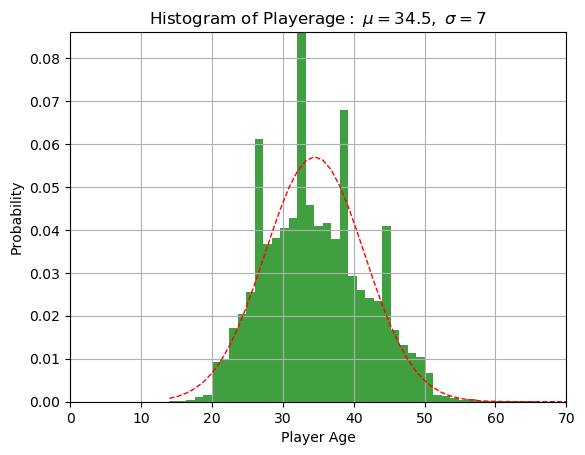

In [43]:
import scipy.stats
mu, sigma = 34.5, 7
#x = mu + sigma*np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(ages_df, 50, density=1, facecolor='green', alpha=0.75)

# add a 'best fit' line
y = scipy.stats.norm.pdf(bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.xlabel('Player Age')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Player age:}\ \mu=34.5,\ \sigma=7$')
plt.axis([0, 70, 0, 0.086])
plt.grid(True)

plt.show()

In [ ]:
####Tottal Distinct number of player and Event
distinct_player=baseline_df.select("Player Name").distinct().count()
distinct_Event=baseline_df.select("Event Name").distinct().count()
print('Number of Distinct player is',distinct_player,',and Event is :',distinct_Event)

In [42]:
#####Finding  columns with Missing value(How Many missing values each columns has (even zero))
missing=baseline_df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in baseline_df.columns))


In [96]:
len(missing.columns)

141

In [45]:
df_missing=missing.toPandas()

In [59]:
####only return columns with missing value
df_missing=df_missing.loc[:, (df_missing != 0).any(axis=0)]


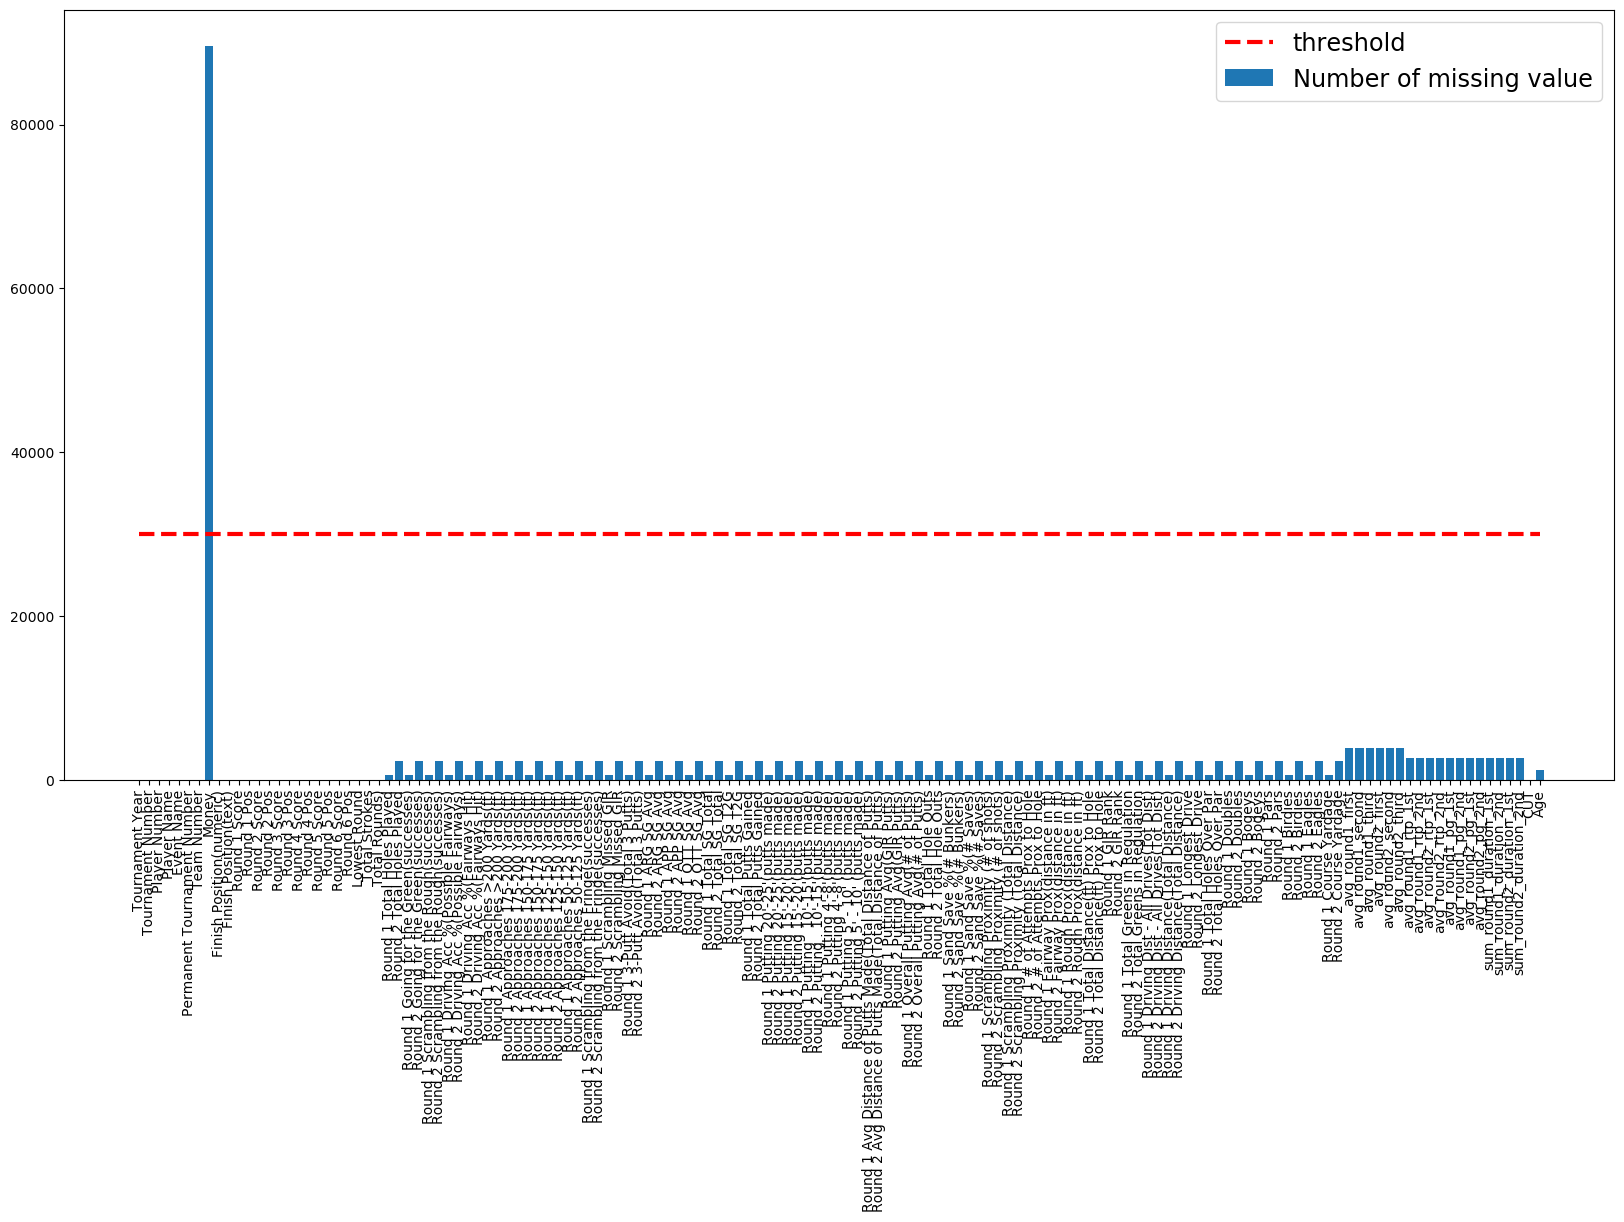

In [46]:
###Missing value graph
y=df_missing.columns
x=df_missing.iloc[0]
plt.figure(figsize=(20,10))
degrees = 90
plt.xticks(rotation=degrees)
plt.bar(y,x)
plt.plot(y,[30000]*len(y),'r--', linewidth=3)
plt.legend(['threshold','Number of missing value'], loc='best', fontsize="xx-large")
plt.show()

In [ ]:
######################DEALING WITH MISSING VALUE#################

In [43]:
#In this section Idropt columns with more than 30000 Null value
# Find columns that count of Null values are less than %35 of the total number of records  
column_inx = [idx for idx, cnt in enumerate(missing.collect()[0]) if cnt < 30000]
column_kept = [missing.columns[i] for i in column_inx]

baseline_df = baseline_df.select(column_kept)


In [44]:
len(baseline_df.columns)

140

In [185]:
baseline_df.columns

['Tournament Year',
 'Tournament Number',
 'Player Number',
 'Player Name',
 'Event Name',
 'Permanent Tournament Number',
 'Team Number',
 'Money',
 'Finish Position(numeric)',
 'Finish Position(text)',
 'Round 1 Score',
 'Round 1 Pos',
 'Round 2 Score',
 'Round 2 Pos',
 'Round 3 Score',
 'Round 3 Pos',
 'Round 4 Score',
 'Round 4 Pos',
 'Round 5 Score',
 'Round 5 Pos',
 'Round 6 Score',
 'Round 6 Pos',
 'Lowest Round',
 'Total Strokes',
 'Total Rounds)',
 'Round 1 Total Holes Played',
 'Round 2 Total Holes Played',
 'Round 1 Going for the Green(successes)',
 'Round 2 Going for the Green(successes)',
 'Round 1 Scrambling from the Rough(successes)',
 'Round 2 Scrambling from the Rough(successes)',
 'Round 1 Driving Acc %(Possible Fairways)',
 'Round 2 Driving Acc %(Possible Fairways)',
 'Round 1 Driving Acc %(Fairways Hit)',
 'Round 2 Driving Acc %(Fairways Hit)',
 'Round 1 Approaches >200 Yards(ft)',
 'Round 2 Approaches >200 Yards(ft)',
 'Round 1 Approaches 175-200 Yards(ft)',
 'Roun

In [25]:
baseline_df = baseline_df.withColumn('CUT', col('CUT').cast("int"))

In [26]:
str_columns = [item[0] for item in baseline_df.dtypes if item[1].startswith('string')]
str_columns

['Player Name', 'Event Name']

In [189]:
baseline_df.select('CUT1', "CUT").show()

+----+-----+
|CUT1|  CUT|
+----+-----+
|   0|false|
|   1| true|
|   0|false|
|   1| true|
|   0|false|
|   1| true|
|   0|false|
|   1| true|
|   0|false|
|   1| true|
|   0|false|
|   0|false|
|   1| true|
|   0|false|
|   0|false|
|   1| true|
|   1| true|
|   1| true|
|   1| true|
|   0|false|
+----+-----+
only showing top 20 rows



In [ ]:
######Filling missing value with mean########

In [18]:
k_columns=['Tournament Year',
 'Tournament Number',
 'Player Number',
  'Permanent Tournament Number',
 'Team Number',
 'Finish Position(numeric)',
  'Round 1 Score',
 'Round 1 Pos',
 'Round 2 Score',
 'Round 2 Pos',
 'Round 3 Score',
 'Round 3 Pos',
 'Round 4 Score',
 'Round 4 Pos',
 'Round 5 Score',
 'Round 5 Pos',
 'Round 6 Score',
 'Round 6 Pos',
 'Lowest Round',
 'Total Strokes',
 'Total Rounds)',
 'Round 1 Total Holes Played',
 'Round 2 Total Holes Played',
 'Round 1 Going for the Green(successes)',
 'Round 2 Going for the Green(successes)',
 'Round 1 Scrambling from the Rough(successes)',
 'Round 2 Scrambling from the Rough(successes)',
 'Round 1 Driving Acc %(Possible Fairways)',
 'Round 2 Driving Acc %(Possible Fairways)',
 'Round 1 Driving Acc %(Fairways Hit)',
 'Round 2 Driving Acc %(Fairways Hit)',
 'Round 1 Approaches >200 Yards(ft)',
 'Round 2 Approaches >200 Yards(ft)',
 'Round 1 Approaches 175-200 Yards(ft)',
 'Round 2 Approaches 175-200 Yards(ft)',
 'Round 1 Approaches 150-175 Yards(ft)',
 'Round 2 Approaches 150-175 Yards(ft)',
 'Round 1 Approaches 125-150 Yards(ft)',
 'Round 2 Approaches 125-150 Yards(ft)',
 'Round 1 Approaches 50-125 Yards(ft)',
 'Round 2 Approaches 50-125 Yards(ft)',
 'Round 1 Scrambling from the Fringe(successes)',
 'Round 2 Scrambling from the Fringe(successes)',
 'Round 1 Scrambling Missed GIR',
 'Round 2 Scrambling Missed GIR',
 'Round 1 3-Putt Avoid(Total 3 Putts)',
 'Round 2 3-Putt Avoid(Total 3 Putts)',
 'Round 1 ARG SG Avg',
 'Round 2 ARG SG Avg',
 'Round 1 APP SG Avg',
 'Round 2 APP SG Avg',
 'Round 1 OTT SG Avg',
 'Round 2 OTT SG Avg',
 'Round 1 Total SG Total',
 'Round 2 Total SG Total',
 'Round 1 Total SG T2G',
 'Round 2 Total SG T2G',
 'Round 1 Total Putts Gained',
 'Round 2 Total Putts Gained',
 "Round 1 Putting 20'-25'(putts made)",
 "Round 2 Putting 20'-25'(putts made)",
 "Round 1 Putting 15'-20'(putts made)",
 "Round 2 Putting 15'-20'(putts made)",
 "Round 1 Putting   10'-15'(putts made)",
 "Round 2 Putting   10'-15'(putts made)",
 "Round 1 Putting 4'-8'(putts made)",
 "Round 2 Putting 4'-8'(putts made)",
 "Round 1 Putting 5' - 10' (putts made)",
 "Round 2 Putting 5' - 10' (putts made)",
 'Round 1 Avg Distance of Putts Made(Total Distance of Putts)',
 'Round 2 Avg Distance of Putts Made(Total Distance of Putts)',
 'Round 1 Putting Avg(GIR Putts)',
 'Round 2 Putting Avg(GIR Putts)',
 'Round 1 Overall Putting Avg(# of Putts)',
 'Round 2 Overall Putting Avg(# of Putts)',
 'Round 1 Total Hole Outs',
 'Round 2 Total Hole Outs',
 'Round 1 Sand Save %(# Bunkers)',
 'Round 2 Sand Save %(# Bunkers)',
 'Round 1 Sand Save %(# Saves)',
 'Round 2 Sand Save %(# Saves)',
 'Round 1 Scrambling Proximity (# of shots)',
 'Round 2 Scrambling Proximity (# of shots)',
 'Round 1 Scrambling Proximity (Total Distance)',
 'Round 2 Scrambling Proximity (Total Distance)',
 'Round 1 # of Attempts Prox to Hole',
 'Round 2 # of Attempts Prox to Hole',
 'Round 1 Fairway Prox(distance in ft)',
 'Round 2 Fairway Prox(distance in ft)',
 'Round 1 Rough Prox(distance in ft)',
 'Round 2 Rough Prox(distance in ft)',
 'Round 1 Total Distance(ft) Prox to Hole',
 'Round 2 Total Distance(ft) Prox to Hole',
 'Round 1 GIR Rank',
 'Round 2 GIR Rank',
 'Round 1 Total Greens in Regulation',
 'Round 2 Total Greens in Regulation',
 'Round 1 Driving Dist - All Drives(Tot Dist)',
 'Round 2 Driving Dist - All Drives(Tot Dist)',
 'Round 1 Driving Distance(Total Distance)',
 'Round 2 Driving Distance(Total Distance)',
 'Round 1 Longest Drive',
 'Round 2 Longest Drive',
 'Round 1 Total Holes Over Par',
 'Round 2 Total Holes Over Par',
 'Round 1 Doubles',
 'Round 2 Doubles',
 'Round 1 Bogeys',
 'Round 2 Bogeys',
 'Round 1 Pars',
 'Round 2 Pars',
 'Round 1 Birdies',
 'Round 2 Birdies',
 'Round 1 Eagles',
 'Round 2 Eagles',
 'Round 1 Course Yardage',
 'Round 2 Course Yardage',
 'avg_round1_first',
 'avg_round1_second',
 'avg_round1_third',
 'avg_round2_first',
 'avg_round2_second',
 'avg_round2_third',
 'avg_round1_rtp_1st',
 'avg_round1_rtp_2nd',
 'avg_round2_rtp_1st',
 'avg_round2_rtp_2nd',
 'avg_round1_pg_1st',
 'avg_round1_pg_2nd',
 'avg_round2_pg_1st',
 'avg_round2_pg_2nd',
 'sum_round1_duration_1st',
 'sum_round1_duration_2nd',
 'sum_round2_duration_1st',
 'sum_round2_duration_2nd',
 'Age']

In [47]:
len(k_columns)

136

In [48]:
# Calculate the mean value
for c in k_columns :
    col_mean = baseline_df.agg({c: 'mean'}).collect()[0][0]
   # Replacing with the mean value for that column
    baseline_df = baseline_df.fillna(col_mean, subset=[c])

In [49]:
baseline_df.columns

['Tournament Year',
 'Tournament Number',
 'Player Number',
 'Player Name',
 'Event Name',
 'Permanent Tournament Number',
 'Team Number',
 'Finish Position(numeric)',
 'Finish Position(text)',
 'Round 1 Score',
 'Round 1 Pos',
 'Round 2 Score',
 'Round 2 Pos',
 'Round 3 Score',
 'Round 3 Pos',
 'Round 4 Score',
 'Round 4 Pos',
 'Round 5 Score',
 'Round 5 Pos',
 'Round 6 Score',
 'Round 6 Pos',
 'Lowest Round',
 'Total Strokes',
 'Total Rounds)',
 'Round 1 Total Holes Played',
 'Round 2 Total Holes Played',
 'Round 1 Going for the Green(successes)',
 'Round 2 Going for the Green(successes)',
 'Round 1 Scrambling from the Rough(successes)',
 'Round 2 Scrambling from the Rough(successes)',
 'Round 1 Driving Acc %(Possible Fairways)',
 'Round 2 Driving Acc %(Possible Fairways)',
 'Round 1 Driving Acc %(Fairways Hit)',
 'Round 2 Driving Acc %(Fairways Hit)',
 'Round 1 Approaches >200 Yards(ft)',
 'Round 2 Approaches >200 Yards(ft)',
 'Round 1 Approaches 175-200 Yards(ft)',
 'Round 2 Approa

In [27]:
from pyspark.sql.functions import sum, col

In [7]:
baseline_df.printSchema()

root
 |-- Tournament Year: integer (nullable = true)
 |-- Tournament Number: integer (nullable = true)
 |-- Player Number: integer (nullable = true)
 |-- Player Name: string (nullable = true)
 |-- Event Name: string (nullable = true)
 |-- Finish Position(numeric): integer (nullable = true)
 |-- Round 1 Score: integer (nullable = true)
 |-- Round 1 Pos: integer (nullable = true)
 |-- Round 2 Score: integer (nullable = true)
 |-- Round 2 Pos: integer (nullable = true)
 |-- Round 3 Score: integer (nullable = true)
 |-- Round 3 Pos: integer (nullable = true)
 |-- Round 4 Score: integer (nullable = true)
 |-- Round 4 Pos: integer (nullable = true)
 |-- Round 5 Score: integer (nullable = true)
 |-- Round 5 Pos: integer (nullable = true)
 |-- Round 6 Score: integer (nullable = true)
 |-- Round 6 Pos: integer (nullable = true)
 |-- Lowest Round: integer (nullable = true)
 |-- Total Strokes: integer (nullable = true)
 |-- Total Rounds): integer (nullable = true)
 |-- Round 1 Total Holes Played:

In [43]:
baseline_df.printSchema()

root
 |-- Tournament Year: string (nullable = true)
 |-- Tournament Number: string (nullable = true)
 |-- Player Number: string (nullable = true)
 |-- Player Name: string (nullable = true)
 |-- Event Name: string (nullable = true)
 |-- Finish Position(numeric): string (nullable = true)
 |-- Round 1 Score: string (nullable = true)
 |-- Round 1 Pos: string (nullable = true)
 |-- Round 2 Score: string (nullable = true)
 |-- Round 2 Pos: string (nullable = true)
 |-- Round 3 Score: string (nullable = true)
 |-- Round 3 Pos: string (nullable = true)
 |-- Round 4 Score: string (nullable = true)
 |-- Round 4 Pos: string (nullable = true)
 |-- Round 5 Score: string (nullable = true)
 |-- Round 5 Pos: string (nullable = true)
 |-- Round 6 Score: string (nullable = true)
 |-- Round 6 Pos: string (nullable = true)
 |-- Lowest Round: string (nullable = true)
 |-- Total Strokes: string (nullable = true)
 |-- Total Rounds): string (nullable = true)
 |-- Round 1 Total Holes Played: string (nullable =

In [34]:
# Calculate the mean value
for c in b :
    col_mean = baseline_df.agg({c: 'mean'}).collect()[0][0]
   # Replacing with the mean value for that column
    baseline_df = baseline_df.fillna(col_mean, subset=[c])

In [ ]:
##########################  Outlier

In [72]:
bounds={}
for col in k_columns:
    quantiles=baseline_df.approxQuantile(col, [0.25, 0.75],0.05)
    IQR= quantiles[1]-quantiles[0]
    bounds[col]=[quantiles[0] - (1.5*IQR), quantiles[1] + (1.5*IQR) ]
 

In [73]:
outliers=baseline_df.select(*[((baseline_df[c]<bounds[c][0]) |
                            (baseline_df[c]>bounds[c][1])).alias(c+'_O') for c in k_columns])   

In [75]:
outliers.columns

['Tournament Year_O',
 'Tournament Number_O',
 'Player Number_O',
 'Permanent Tournament Number_O',
 'Team Number_O',
 'Finish Position(numeric)_O',
 'Round 1 Score_O',
 'Round 1 Pos_O',
 'Round 2 Score_O',
 'Round 2 Pos_O',
 'Round 3 Score_O',
 'Round 3 Pos_O',
 'Round 4 Score_O',
 'Round 4 Pos_O',
 'Round 5 Score_O',
 'Round 5 Pos_O',
 'Round 6 Score_O',
 'Round 6 Pos_O',
 'Lowest Round_O',
 'Total Strokes_O',
 'Total Rounds)_O',
 'Round 1 Total Holes Played_O',
 'Round 2 Total Holes Played_O',
 'Round 1 Going for the Green(successes)_O',
 'Round 2 Going for the Green(successes)_O',
 'Round 1 Scrambling from the Rough(successes)_O',
 'Round 2 Scrambling from the Rough(successes)_O',
 'Round 1 Driving Acc %(Possible Fairways)_O',
 'Round 2 Driving Acc %(Possible Fairways)_O',
 'Round 1 Driving Acc %(Fairways Hit)_O',
 'Round 2 Driving Acc %(Fairways Hit)_O',
 'Round 1 Approaches >200 Yards(ft)_O',
 'Round 2 Approaches >200 Yards(ft)_O',
 'Round 1 Approaches 175-200 Yards(ft)_O',
 'Rou

In [78]:
str_out = [item[0] for item in outliers.dtypes if item[1].startswith('string')]
str_out

[]

In [80]:
outliers.printSchema()

root
 |-- Tournament Year_O: boolean (nullable = true)
 |-- Tournament Number_O: boolean (nullable = true)
 |-- Player Number_O: boolean (nullable = true)
 |-- Permanent Tournament Number_O: boolean (nullable = true)
 |-- Team Number_O: boolean (nullable = true)
 |-- Finish Position(numeric)_O: boolean (nullable = true)
 |-- Round 1 Score_O: boolean (nullable = true)
 |-- Round 1 Pos_O: boolean (nullable = true)
 |-- Round 2 Score_O: boolean (nullable = true)
 |-- Round 2 Pos_O: boolean (nullable = true)
 |-- Round 3 Score_O: boolean (nullable = true)
 |-- Round 3 Pos_O: boolean (nullable = true)
 |-- Round 4 Score_O: boolean (nullable = true)
 |-- Round 4 Pos_O: boolean (nullable = true)
 |-- Round 5 Score_O: boolean (nullable = true)
 |-- Round 5 Pos_O: boolean (nullable = true)
 |-- Round 6 Score_O: boolean (nullable = true)
 |-- Round 6 Pos_O: boolean (nullable = true)
 |-- Lowest Round_O: boolean (nullable = true)
 |-- Total Strokes_O: boolean (nullable = true)
 |-- Total Rounds)_

In [160]:
outlier_c=outliers.select(*(sum(col(c).cast("int")).alias(c) for c in outliers.columns))

In [161]:
outc=outliers.select(*(sum(col(c).cast("int")).alias(c) for c in outliers.columns)).toPandas()

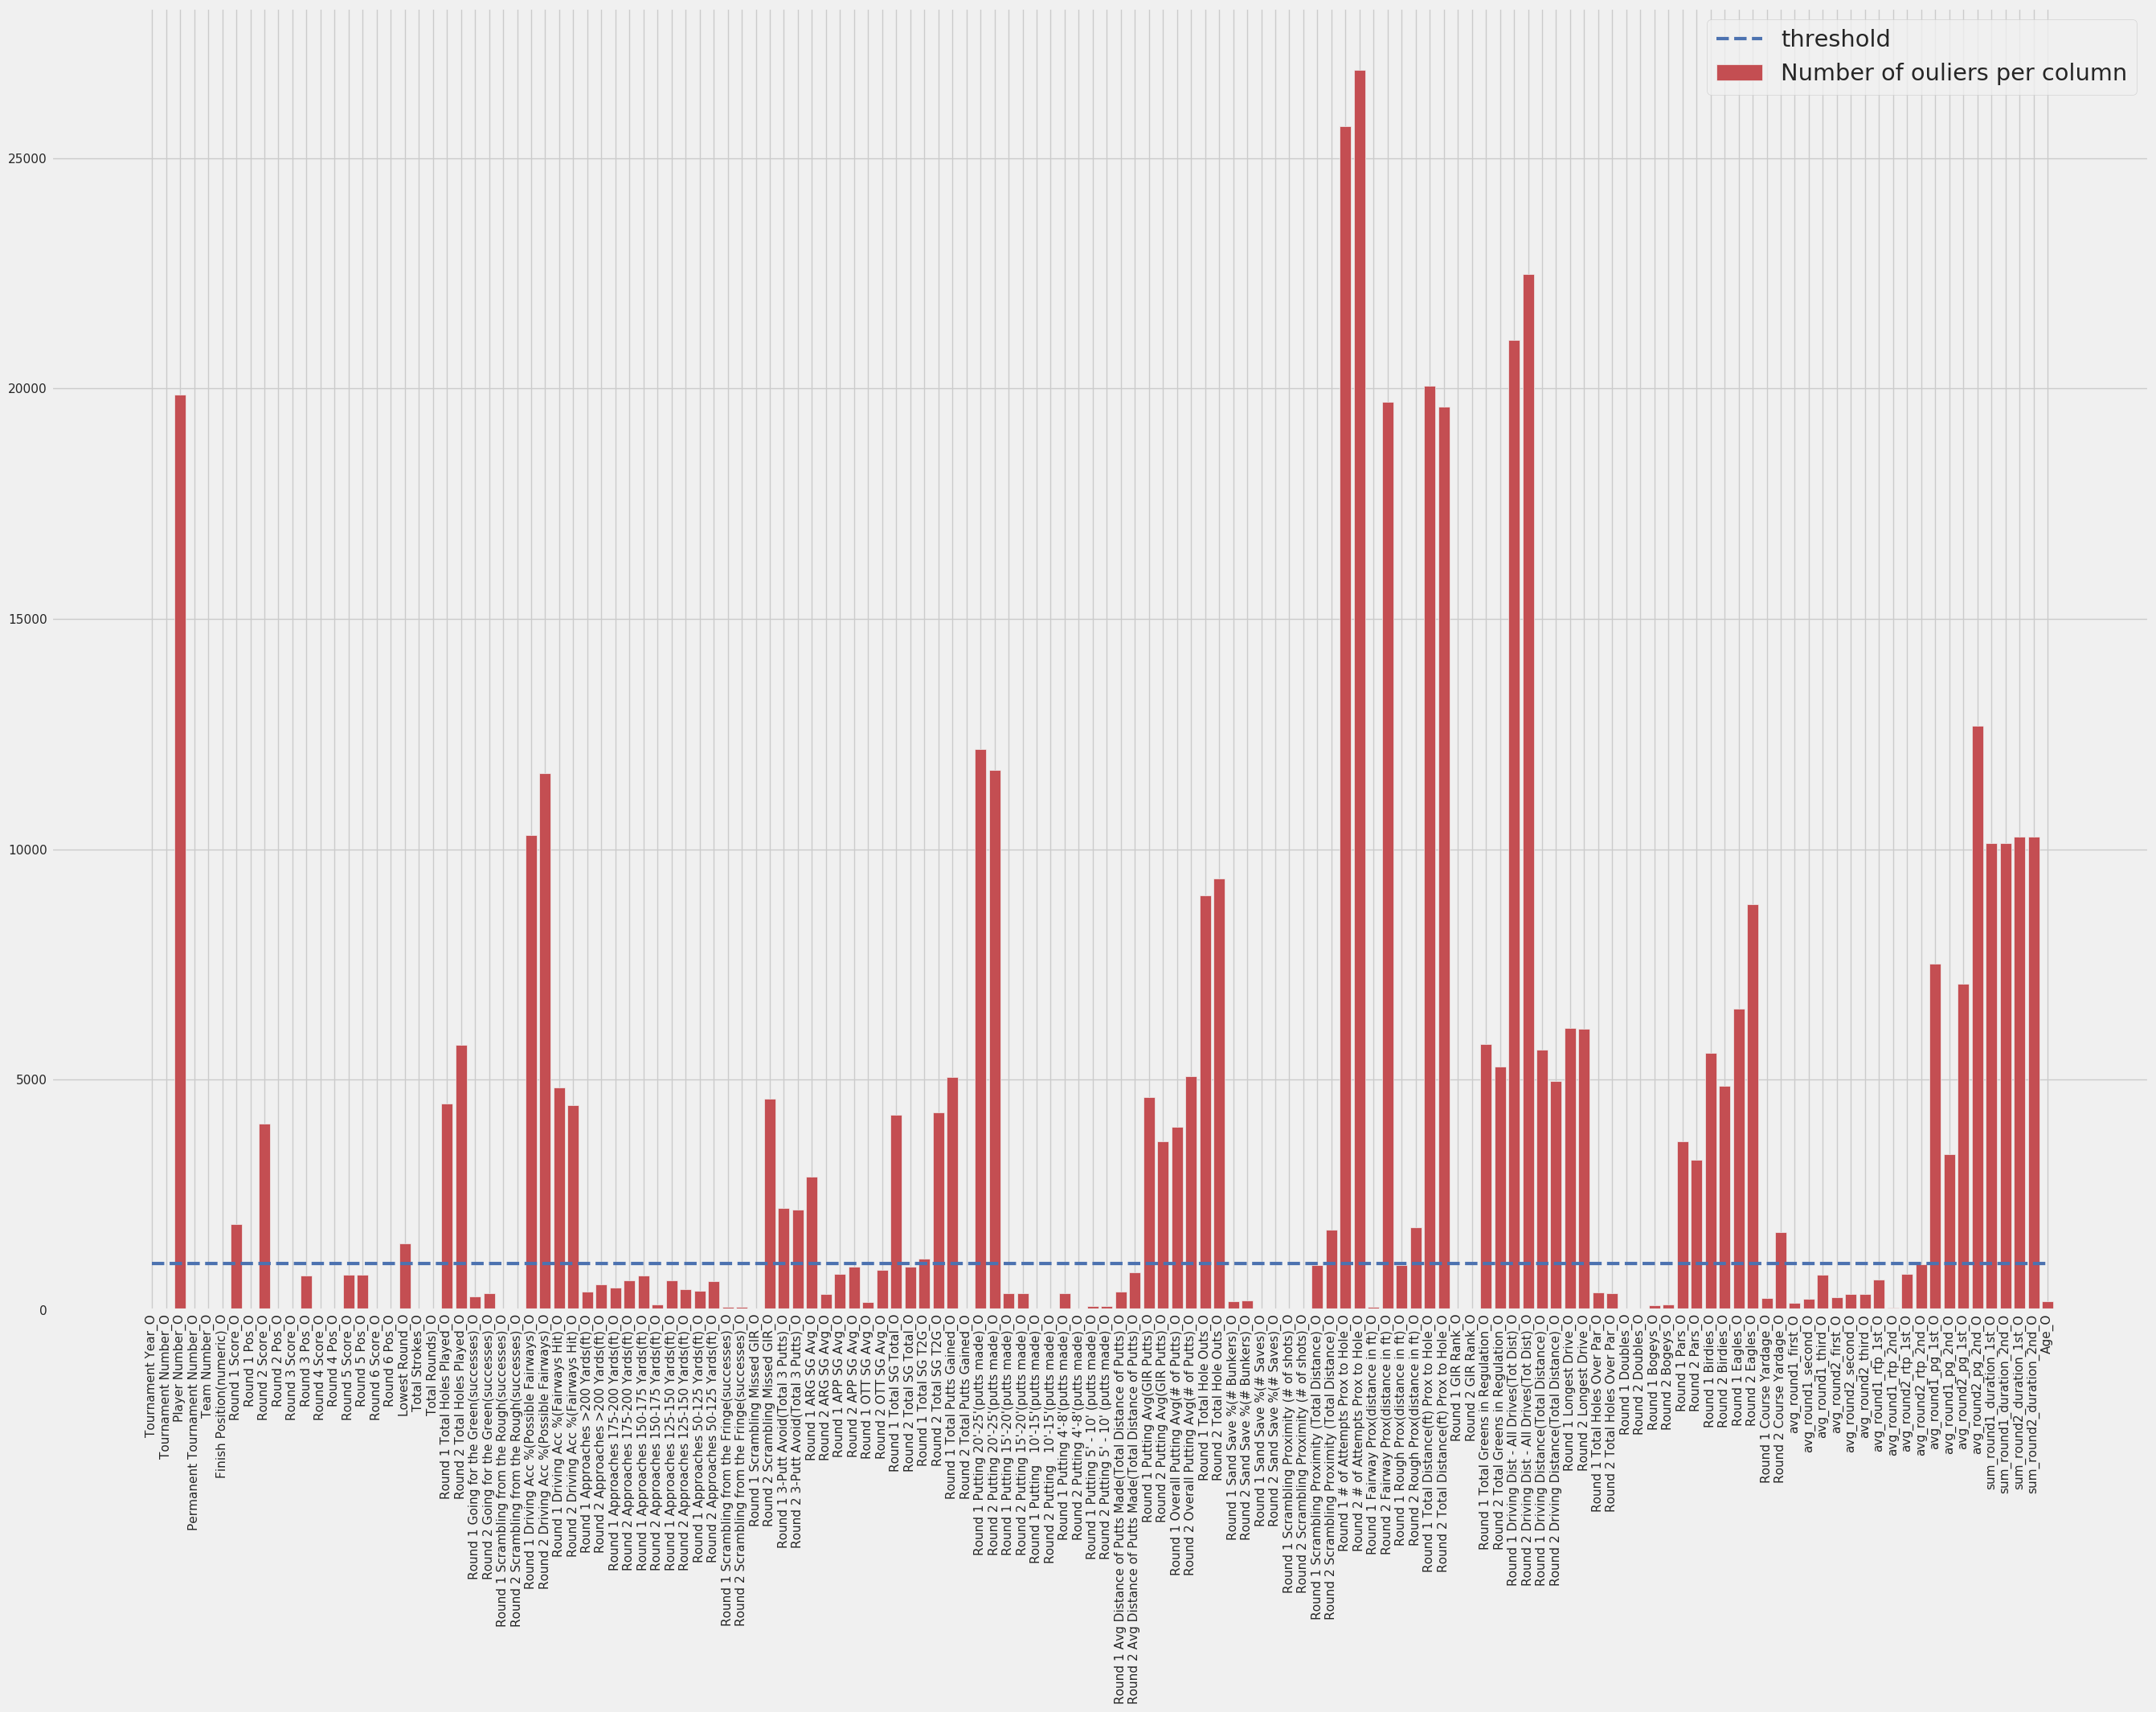

In [162]:
###oulier value graph
y=outc.columns
x=outc.iloc[0]
plt.figure(figsize=(30,20))
degrees = 90
plt.xticks(rotation=degrees)
plt.bar(y,x,color='r')
plt.plot(y,[1000]*len(y),'b--', linewidth=3)
plt.legend(['threshold','Number of ouliers per column'], loc='best', fontsize="xx-large")
plt.show()

In [83]:
##### #### We can use the correlation matrix of the predictors to find colinearity between any two predictors
### We have a selected a list of samples of numeric columns to illustration

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=k_columns, outputCol=vector_col)
df_vector = assembler.transform(baseline_df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [86]:
matrix.collect()[0]["pearson({})".format(vector_col)].values

array([ 1.        , -0.00792296,  0.53035352, ..., -0.0102426 ,
       -0.01628453,  1.        ])

In [95]:
#### We can use the correlation matrix of the predictors to find colinearity between any two predictors
### We have a selected a list of samples of numeric columns to illustration

def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

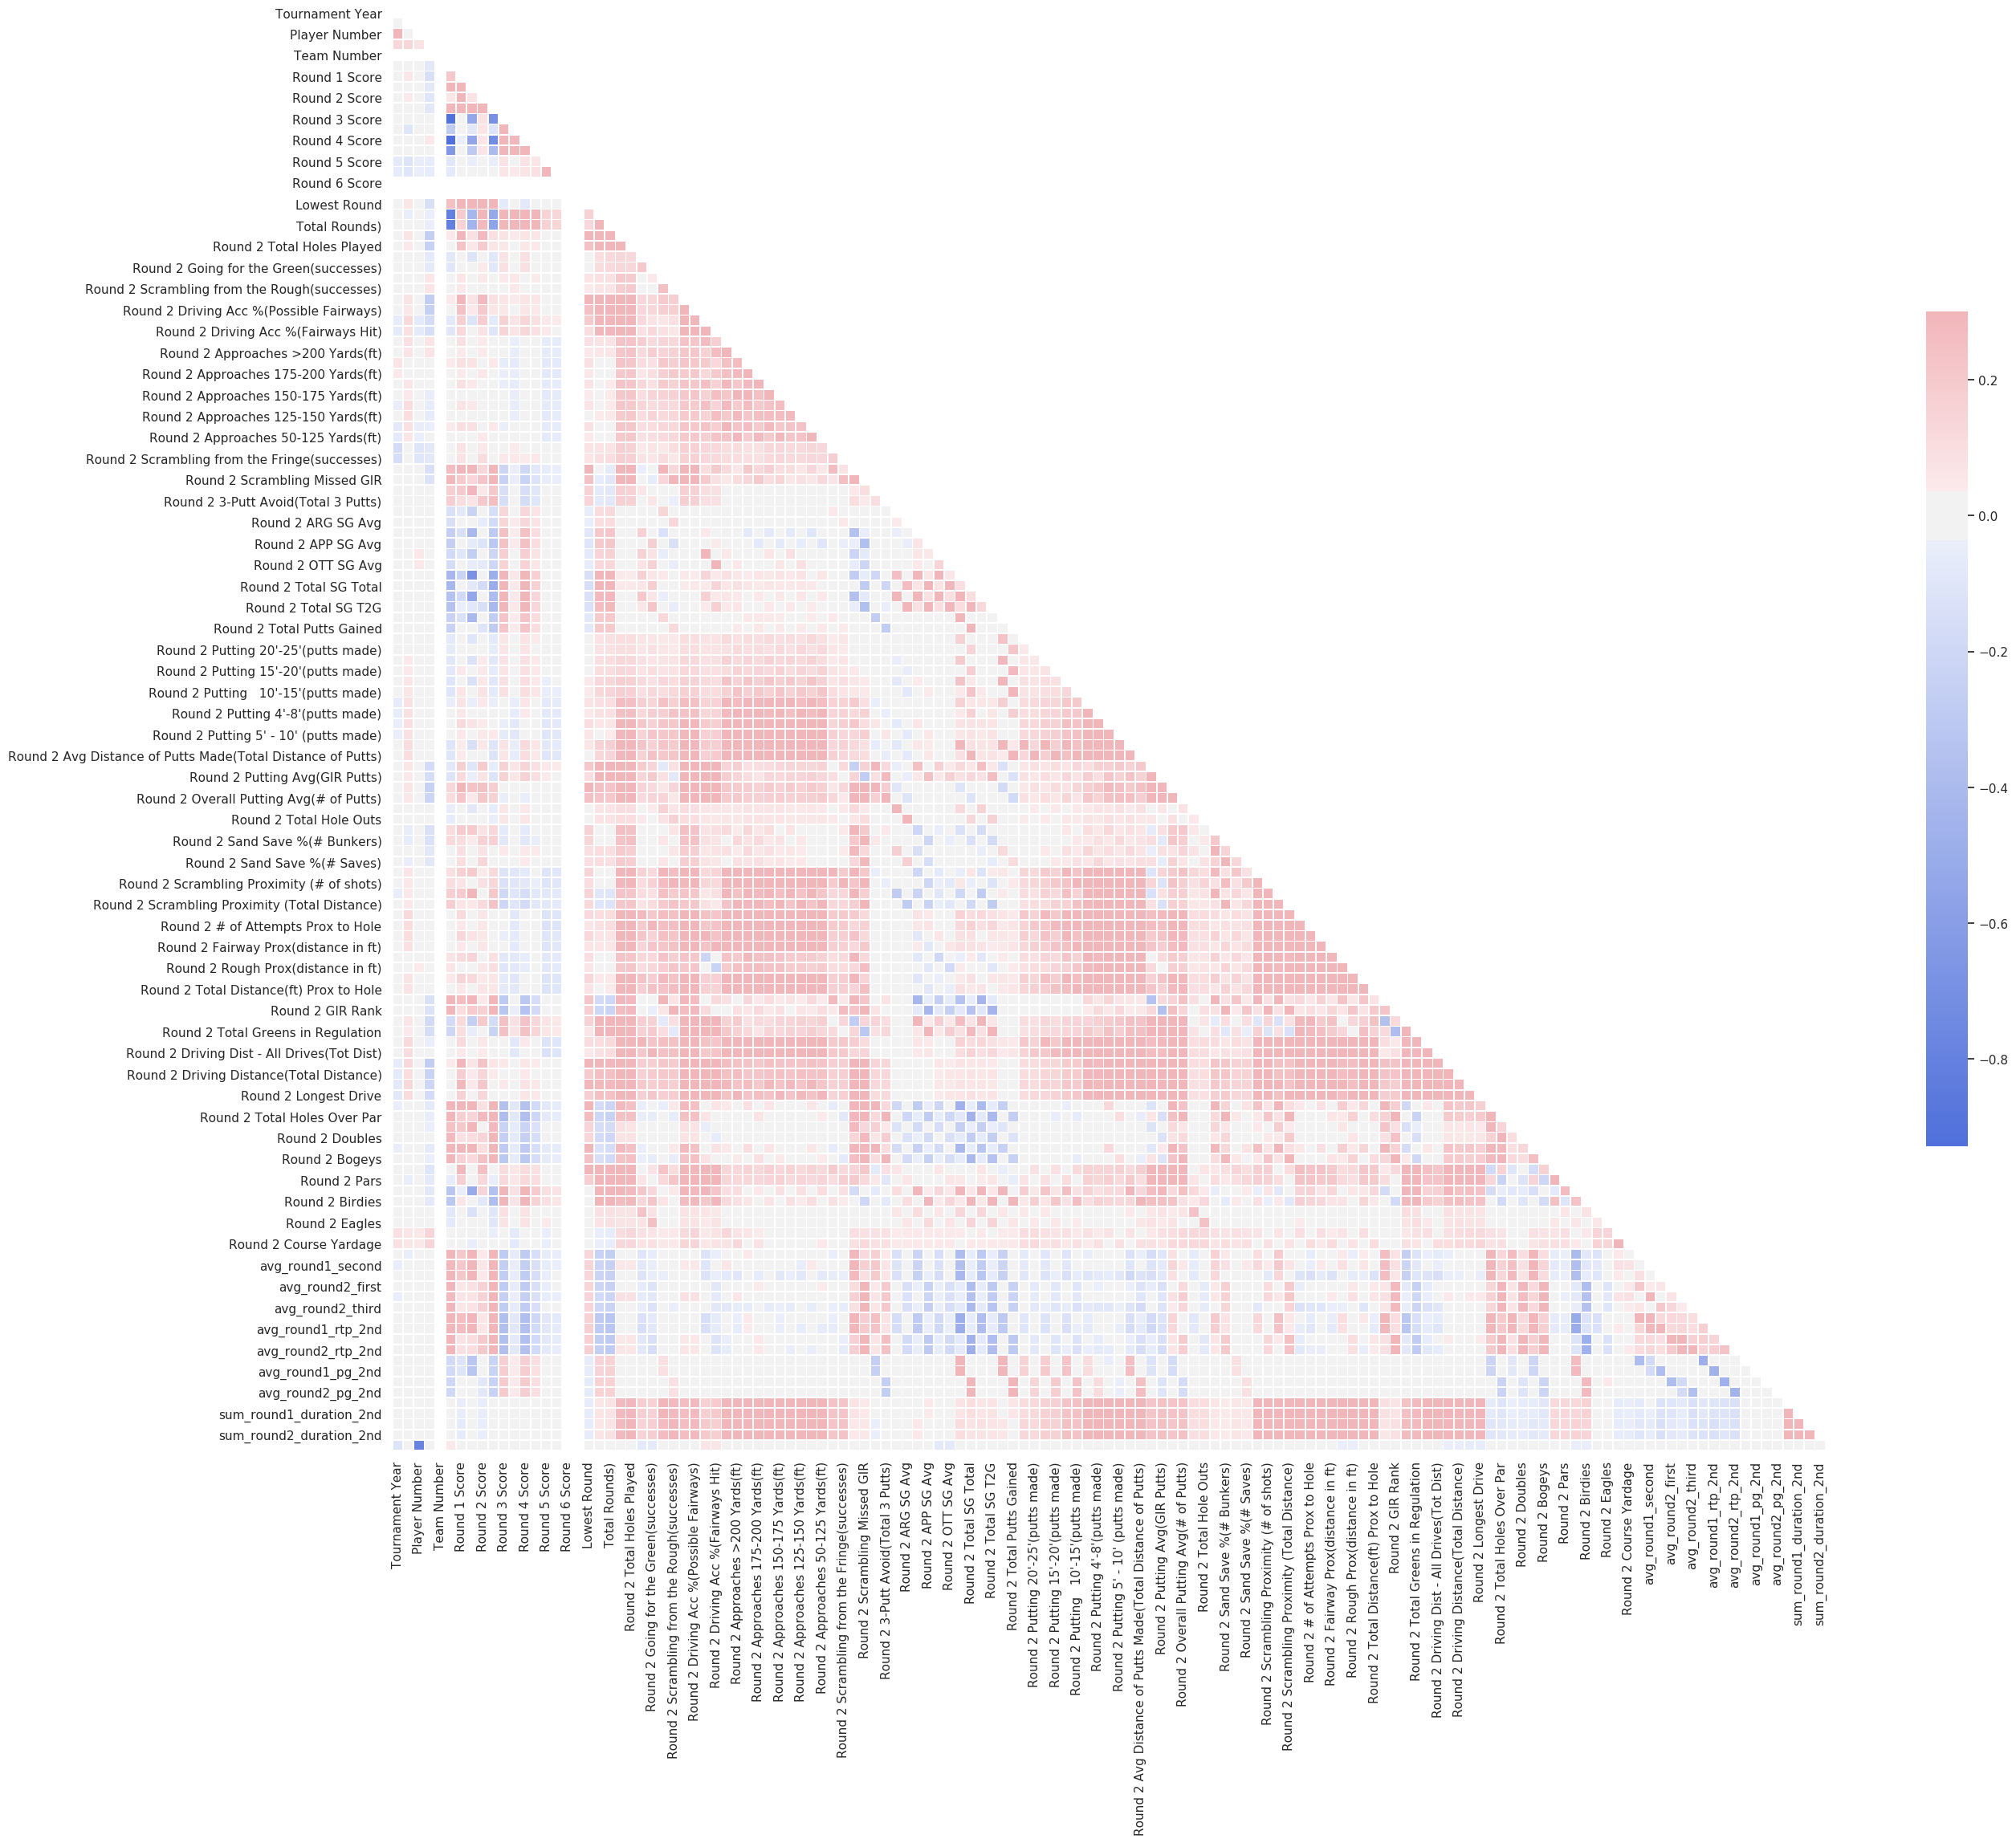

In [104]:
# Generate a mask for the upper triangle
sns.set(style="white")
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(29, 27))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
from pyspark.sql.functions import when

# Calculate the median value
for c in outlier_df.columns[4:] :
    col_median = result_df.approxQuantile(c[:-2], [0.5], 0.05)[0]
   # Replacing with the median value for that column
    result_df = result_df.withColumn(c[:-2] + "_I", when(result_df[c] == True, col_median).otherwise(result_df[c[:-2]]))

In [87]:
##### Base on correlation and oulier these columns are selected for next steps 
cbest=['Tournament Year',
 'Tournament Number',
 'Permanent Tournament Number',
 'Team Number',
 'Player Number',
 'Player Name',
 'Event Name',
 'FedExCup Points','Finish Position(numeric)',
 'Round 1 Pos',
 'Round 2 Pos',
 'Round 3 Score',
 'Round 4 Score',
 'Round 4 Pos',
 'Round 5 Score',
 'Round 5 Pos',
 'Round 6 Score',
 'Round 6 Pos',
 'Total Strokes',
 'Total Rounds)',
 'Stroke Average (Rank)_I',
 'Scoring Avg(Total Adjustment - Rank)',
 'Eagles (Rank)',
 'Birdies',
 'Birdies (Rank)',
 'Pars',
 'Bogeys (Rank)',
 'Bogey Avoidance Rank_I',
 'Birdie or Better Conv %(# Birdies)_I',
 'Birdie or Better Conv %(# Greens Hit)_I',
 'Driving Distance(Total Distance)_I',
 'Driving Distance(Total Drives)_I',
 'Driving Distance (Rank)_I',
 'Driving Dist - All Drives(Tot Dist)_I',
 'Driving Dist - All Drives(Rank)_I',
 'Driving Acc %(Fairways Hit)_I',
 'Driving Acc %(Possible Fairways)_I',
 'Driving Accuracy Rank',
 'Total Driving (Rank)',
 'Total Holes Played',
 'Total Greens in Regulation_I',
 'GIR Rank',
 '# of Attempts Prox to Hole_I',
 'Fairway Prox(attempts)_I',
 'Fairway Prox (Rank)',
 'Rough Prox(attempts)_I',
 'Rough Prox (Rank)',
 'Scrambling Par or Better_I',
 'Scrambling Missed GIR_I',
 'Scrambling (Rank)',
 'Scrambling Proximity (rank)_I',
 'Scrambling from the Rough(successes)_I',
 'Scrambling from the Rough(attempts)_I',
 'Scrambling from the Fringe(attempts)_I',
  'Sand Save (Rank)',
 'Total Hole Outs',
 'Overall Putting Avg(# of Putts)',
 'Putting Avg(GIR Putts)_I',
 'One-Putt %(# of One Putts)_I',
 'Approach Putt Performance(attempts)_I',
 'Avg Distance of Putts Made(Total Distance of Putts)',
 'Total Rounds Played',
 "Putting 3'(attempts)_I",
   "Putting 5'(attempts)_I",
  "Putting 8'(attempts)_I",
 "Putting 9'(attempts)_I",
 "Putting Inside 5' (putts made)_I",
 "Putting Inside 5' (attempts)_I",
 'Putting Inside 5 Feet (Rank)_I',
 'Total Rounds Played(Putts Gained)',
 'Putts Gained Rank',
 'SG: T2G Rank',
 'SG: Total Rank',
 'OTT SG Rank',
 'APP SG Rank',
 'ARG SG Rank',
 'Age']

In [ ]:
##################Example 

In [82]:
result_df.filter(col("Driving Distance(Total Distance)_O")).select(["Driving Distance(Total Distance)","Driving Distance(Total Distance)_O", "Driving Distance(Total Distance)_I"]).show()

+--------------------------------+----------------------------------+----------------------------------+
|Driving Distance(Total Distance)|Driving Distance(Total Distance)_O|Driving Distance(Total Distance)_I|
+--------------------------------+----------------------------------+----------------------------------+
+--------------------------------+----------------------------------+----------------------------------+



In [ ]:
result_df.select(["Putting 10'-15'(rank)","Putting 10'-15'(rank)_O", "Putting 10'-15'(rank)_I"]).show()

In [83]:
result_df.filter(col("Round 3 Score_O")).select(["Round 3 Score","Round 3 Score_O", "Round 3 Score_I"]).show()



+-------------+---------------+---------------+
|Round 3 Score|Round 3 Score_O|Round 3 Score_I|
+-------------+---------------+---------------+
+-------------+---------------+---------------+



In [222]:
baseline_df.filter(col('Finish Position(numeric)')==1).select(['Finish Position(numeric)','Player Name']).show()

+------------------------+----------------+
|Finish Position(numeric)|     Player Name|
+------------------------+----------------+
|                       1|  Garcia, Sergio|
|                       1| Appleby, Stuart|
|                       1|    Wilson, Dean|
|                       1|Vegas, Jhonattan|
|                       1|  Thomas, Justin|
|                       1| Johnson, Dustin|
|                       1|Bradley, Michael|
|                       1| Wagner, Johnson|
|                       1|Villegas, Camilo|
|                       1|   Ogilvy, Geoff|
|                       1| Stricker, Steve|
|                       1|     Bohn, Jason|
|                       1|  Campbell, Chad|
|                       1|Immelman, Trevor|
|                       1| Mickelson, Phil|
|                       1|    Poulter, Ian|
|                       1|Stallings, Scott|
|                       1|   Simpson, Webb|
|                       1|   Merritt, Troy|
|                       1|    Lo

In [227]:
baseline_df.columns

['Tournament Year',
 'Tournament Number',
 'Player Number',
 'Player Name',
 'Event Name',
 'Permanent Tournament Number',
 'Team Number',
 'Money',
 'Finish Position(numeric)',
 'Finish Position(text)',
 'Round 1 Score',
 'Round 1 Pos',
 'Round 2 Score',
 'Round 2 Pos',
 'Round 3 Score',
 'Round 3 Pos',
 'Round 4 Score',
 'Round 4 Pos',
 'Round 5 Score',
 'Round 5 Pos',
 'Round 6 Score',
 'Round 6 Pos',
 'Lowest Round',
 'Total Strokes',
 'Total Rounds)',
 'Round 1 Total Holes Played',
 'Round 2 Total Holes Played',
 'Round 1 Going for the Green(successes)',
 'Round 2 Going for the Green(successes)',
 'Round 1 Scrambling from the Rough(successes)',
 'Round 2 Scrambling from the Rough(successes)',
 'Round 1 Driving Acc %(Possible Fairways)',
 'Round 2 Driving Acc %(Possible Fairways)',
 'Round 1 Driving Acc %(Fairways Hit)',
 'Round 2 Driving Acc %(Fairways Hit)',
 'Round 1 Approaches >200 Yards(ft)',
 'Round 2 Approaches >200 Yards(ft)',
 'Round 1 Approaches 175-200 Yards(ft)',
 'Roun

In [17]:
baseline_df=spark.read.csv('./ppmycsv2.csv',header=True, sep=',',inferSchema=True)

In [18]:
from pyspark.sql.functions import sum, col

In [19]:
b=['Tournament Year',
 'Tournament Number',
 'Player Number',
 'Finish Position(numeric)',
 'Round 1 Score',
 'Round 1 Pos',
 'Round 2 Score',
 'Round 2 Pos',
 'Round 3 Score',
 'Round 3 Pos',
 'Round 4 Score',
 'Round 4 Pos',
 'Round 5 Score',
 'Round 5 Pos',
 'Round 6 Score',
 'Round 6 Pos',
 'Lowest Round',
 'Total Strokes',
 'Total Rounds)',
 'Round 1 Total Holes Played',
 'Round 2 Total Holes Played',
 'Round 1 Going for the Green(successes)',
 'Round 2 Going for the Green(successes)',
 'Round 1 Scrambling from the Rough(successes)',
 'Round 2 Scrambling from the Rough(successes)',
 'Round 1 Driving Acc %(Possible Fairways)',
 'Round 2 Driving Acc %(Possible Fairways)',
 'Round 1 Driving Acc %(Fairways Hit)',
 'Round 2 Driving Acc %(Fairways Hit)',
 'Round 1 Approaches >200 Yards(ft)',
 'Round 2 Approaches >200 Yards(ft)',
 'Round 1 Approaches 175-200 Yards(ft)',
 'Round 2 Approaches 175-200 Yards(ft)',
 'Round 1 Approaches 150-175 Yards(ft)',
 'Round 2 Approaches 150-175 Yards(ft)',
 'Round 1 Approaches 125-150 Yards(ft)',
 'Round 2 Approaches 125-150 Yards(ft)',
 'Round 1 Approaches 50-125 Yards(ft)',
 'Round 2 Approaches 50-125 Yards(ft)',
 'Round 1 Scrambling from the Fringe(successes)',
 'Round 2 Scrambling from the Fringe(successes)',
 'Round 1 Scrambling Missed GIR',
 'Round 2 Scrambling Missed GIR',
 'Round 1 3-Putt Avoid(Total 3 Putts)',
 'Round 2 3-Putt Avoid(Total 3 Putts)',
 'Round 1 ARG SG Avg',
 'Round 2 ARG SG Avg',
 'Round 1 APP SG Avg',
 'Round 2 APP SG Avg',
 'Round 1 OTT SG Avg',
 'Round 2 OTT SG Avg',
 'Round 1 Total SG Total',
 'Round 2 Total SG Total',
 'Round 1 Total SG T2G',
 'Round 2 Total SG T2G',
 'Round 1 Total Putts Gained',
 'Round 2 Total Putts Gained',
 "Round 1 Putting 20'-25'(putts made)",
 "Round 2 Putting 20'-25'(putts made)",
 "Round 1 Putting 15'-20'(putts made)",
 "Round 2 Putting 15'-20'(putts made)",
 "Round 1 Putting   10'-15'(putts made)",
 "Round 2 Putting   10'-15'(putts made)",
 "Round 1 Putting 4'-8'(putts made)",
 "Round 2 Putting 4'-8'(putts made)",
 "Round 1 Putting 5' - 10' (putts made)",
 "Round 2 Putting 5' - 10' (putts made)",
 'Round 1 Avg Distance of Putts Made(Total Distance of Putts)',
 'Round 2 Avg Distance of Putts Made(Total Distance of Putts)',
 'Round 1 Putting Avg(GIR Putts)',
 'Round 2 Putting Avg(GIR Putts)',
 'Round 1 Overall Putting Avg(# of Putts)',
 'Round 2 Overall Putting Avg(# of Putts)',
 'Round 1 Total Hole Outs',
 'Round 2 Total Hole Outs',
 'Round 1 Sand Save %(# Bunkers)',
 'Round 2 Sand Save %(# Bunkers)',
 'Round 1 Sand Save %(# Saves)',
 'Round 2 Sand Save %(# Saves)',
 'Round 1 Scrambling Proximity (# of shots)',
 'Round 2 Scrambling Proximity (# of shots)',
 'Round 1 Scrambling Proximity (Total Distance)',
 'Round 2 Scrambling Proximity (Total Distance)',
 'Round 1 # of Attempts Prox to Hole',
 'Round 2 # of Attempts Prox to Hole',
 'Round 1 Fairway Prox(distance in ft)',
 'Round 2 Fairway Prox(distance in ft)',
 'Round 1 Rough Prox(distance in ft)',
 'Round 2 Rough Prox(distance in ft)',
 'Round 1 Total Distance(ft) Prox to Hole',
 'Round 2 Total Distance(ft) Prox to Hole',
 'Round 1 GIR Rank',
 'Round 2 GIR Rank',
 'Round 1 Total Greens in Regulation',
 'Round 2 Total Greens in Regulation',
 'Round 1 Driving Dist - All Drives(Tot Dist)',
 'Round 2 Driving Dist - All Drives(Tot Dist)',
 'Round 1 Driving Distance(Total Distance)',
 'Round 2 Driving Distance(Total Distance)',
 'Round 1 Longest Drive',
 'Round 2 Longest Drive',
 'Round 1 Total Holes Over Par',
 'Round 2 Total Holes Over Par',
 'Round 1 Doubles',
 'Round 2 Doubles',
 'Round 1 Bogeys',
 'Round 2 Bogeys',
 'Round 1 Pars',
 'Round 2 Pars',
 'Round 1 Birdies',
 'Round 2 Birdies',
 'Round 1 Eagles',
 'Round 2 Eagles',
 'Round 1 Course Yardage',
 'Round 2 Course Yardage',
 'avg_round1_first',
 'avg_round1_second',
 'avg_round1_third',
 'avg_round2_first',
 'avg_round2_second',
 'avg_round2_third',
 'avg_round1_rtp_1st',
 'avg_round1_rtp_2nd',
 'avg_round2_rtp_1st',
 'avg_round2_rtp_2nd',
 'avg_round1_pg_1st',
 'avg_round1_pg_2nd',
 'avg_round2_pg_1st',
 'avg_round2_pg_2nd',
 'sum_round1_duration_1st',
 'sum_round1_duration_2nd',
 'sum_round2_duration_1st',
 'sum_round2_duration_2nd',
 'Age']

In [20]:
baseline_df = baseline_df.fillna(1, subset=['CUT'])

In [21]:
# Calculate the mean value
for c in b :
    col_mean = baseline_df.agg({c: 'mean'}).collect()[0][0]
   # Replacing with the mean value for that column
    baseline_df = baseline_df.fillna(col_mean, subset=[c])

In [ ]:
############### PCA

In [22]:
z_columns=['Tournament Year',
 'Tournament Number',
 'Round 1 Score',
 'Round 1 Pos',
 'Round 2 Score',
 'Round 2 Pos',
 'Round 1 Total Holes Played',
 'Round 2 Total Holes Played',
 'Round 1 Going for the Green(successes)',
 'Round 2 Going for the Green(successes)',
 'Round 1 Scrambling from the Rough(successes)',
 'Round 2 Scrambling from the Rough(successes)',
 'Round 1 Driving Acc %(Possible Fairways)',
 'Round 2 Driving Acc %(Possible Fairways)',
 'Round 1 Driving Acc %(Fairways Hit)',
 'Round 2 Driving Acc %(Fairways Hit)',
 'Round 1 Approaches >200 Yards(ft)',
 'Round 2 Approaches >200 Yards(ft)',
 'Round 1 Approaches 175-200 Yards(ft)',
 'Round 2 Approaches 175-200 Yards(ft)',
 'Round 1 Approaches 150-175 Yards(ft)',
 'Round 2 Approaches 150-175 Yards(ft)',
 'Round 1 Approaches 125-150 Yards(ft)',
 'Round 2 Approaches 125-150 Yards(ft)',
 'Round 1 Approaches 50-125 Yards(ft)',
 'Round 2 Approaches 50-125 Yards(ft)',
 'Round 1 Scrambling from the Fringe(successes)',
 'Round 2 Scrambling from the Fringe(successes)',
 'Round 1 Scrambling Missed GIR',
 'Round 2 Scrambling Missed GIR',
 'Round 1 3-Putt Avoid(Total 3 Putts)',
 'Round 2 3-Putt Avoid(Total 3 Putts)',
 'Round 1 ARG SG Avg',
 'Round 2 ARG SG Avg',
 'Round 1 APP SG Avg',
 'Round 2 APP SG Avg',
 'Round 1 OTT SG Avg',
 'Round 2 OTT SG Avg',
 'Round 1 Total SG Total',
 'Round 2 Total SG Total',
 'Round 1 Total SG T2G',
 'Round 2 Total SG T2G',
 'Round 1 Total Putts Gained',
 'Round 2 Total Putts Gained',
 "Round 1 Putting 20'-25'(putts made)",
 "Round 2 Putting 20'-25'(putts made)",
 "Round 1 Putting 15'-20'(putts made)",
 "Round 2 Putting 15'-20'(putts made)",
 "Round 1 Putting   10'-15'(putts made)",
 "Round 2 Putting   10'-15'(putts made)",
 "Round 1 Putting 4'-8'(putts made)",
 "Round 2 Putting 4'-8'(putts made)",
 "Round 1 Putting 5' - 10' (putts made)",
 "Round 2 Putting 5' - 10' (putts made)",
 'Round 1 Avg Distance of Putts Made(Total Distance of Putts)',
 'Round 2 Avg Distance of Putts Made(Total Distance of Putts)',
 'Round 1 Putting Avg(GIR Putts)',
 'Round 2 Putting Avg(GIR Putts)',
 'Round 1 Overall Putting Avg(# of Putts)',
 'Round 2 Overall Putting Avg(# of Putts)',
 'Round 1 Total Hole Outs',
 'Round 2 Total Hole Outs',
 'Round 1 Sand Save %(# Bunkers)',
 'Round 2 Sand Save %(# Bunkers)',
 'Round 1 Sand Save %(# Saves)',
 'Round 2 Sand Save %(# Saves)',
 'Round 1 Scrambling Proximity (# of shots)',
 'Round 2 Scrambling Proximity (# of shots)',
 'Round 1 Scrambling Proximity (Total Distance)',
 'Round 2 Scrambling Proximity (Total Distance)',
 'Round 1 # of Attempts Prox to Hole',
 'Round 2 # of Attempts Prox to Hole',
 'Round 1 Fairway Prox(distance in ft)',
 'Round 2 Fairway Prox(distance in ft)',
 'Round 1 Rough Prox(distance in ft)',
 'Round 2 Rough Prox(distance in ft)',
 'Round 1 Total Distance(ft) Prox to Hole',
 'Round 2 Total Distance(ft) Prox to Hole',
 'Round 1 GIR Rank',
 'Round 2 GIR Rank',
 'Round 1 Total Greens in Regulation',
 'Round 2 Total Greens in Regulation',
 'Round 1 Driving Dist - All Drives(Tot Dist)',
 'Round 2 Driving Dist - All Drives(Tot Dist)',
 'Round 1 Driving Distance(Total Distance)',
 'Round 2 Driving Distance(Total Distance)',
 'Round 1 Longest Drive',
 'Round 2 Longest Drive',
 'Round 1 Total Holes Over Par',
 'Round 2 Total Holes Over Par',
 'Round 1 Doubles',
 'Round 2 Doubles',
 'Round 1 Bogeys',
 'Round 2 Bogeys',
 'Round 1 Pars',
 'Round 2 Pars',
 'Round 1 Birdies',
 'Round 2 Birdies',
 'Round 1 Eagles',
 'Round 2 Eagles',
 'Round 1 Course Yardage',
 'Round 2 Course Yardage',
 'avg_round1_first',
 'avg_round1_second',
 'avg_round1_third',
 'avg_round2_first',
 'avg_round2_second',
 'avg_round2_third',
 'avg_round1_rtp_1st',
 'avg_round1_rtp_2nd',
 'avg_round2_rtp_1st',
 'avg_round2_rtp_2nd',
 'avg_round1_pg_1st',
 'avg_round1_pg_2nd',
 'avg_round2_pg_1st',
 'avg_round2_pg_2nd',
 'sum_round1_duration_1st',
 'sum_round1_duration_2nd',
 'sum_round2_duration_1st',
 'sum_round2_duration_2nd',
 'Age']

In [35]:
len(z_columns)

121

In [ ]:
#### n order to train ML models in Spark later, we'll use the VectorAssembler to combine a given list of C_columns into a single vector column.

In [23]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
# # the combined output column's name
assembler= VectorAssembler(
    inputCols =z_columns, outputCol = 'features')

# use it to transform the dataset and select just
# the output column
df = assembler.transform(baseline_df).select('features')


In [13]:
df.show(2)

+--------------------+
|            features|
+--------------------+
|[2003.0,10.0,69.0...|
|[2003.0,30.0,70.0...|
+--------------------+
only showing top 2 rows



In [ ]:
###we standardize the features, notice here we only need to specify the assembled column as the input feature.

In [24]:
scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures',withMean =True,withStd = True).fit(df)



In [25]:
# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(df)


In [ ]:
##### After the preprocessing step, we fit the PCA model.

In [ ]:
# call PCA specifying we only want the
# first two principal components (since
# we only have a 2d datset)

In [131]:
n_components = 90
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())
df_pca.show(6)

Explained Variance Ratio [0.18239636 0.08979403 0.07264239 0.05018031 0.03006507 0.02861109
 0.02104078 0.02029422 0.0182728  0.01712965 0.01562789 0.01502371
 0.01471859 0.01425289 0.01362457 0.01326112 0.0129259  0.01187115
 0.01077662 0.01055734 0.01028257 0.0099952  0.00947145 0.00926937
 0.00880639 0.00870055 0.00825698 0.00823282 0.00814923 0.00793471
 0.00762475 0.00757561 0.00743825 0.00736189 0.00720912 0.00710802
 0.00705846 0.00671062 0.00664962 0.00653727 0.00645766 0.0063443
 0.00617623 0.00611801 0.00606567 0.00598259 0.00597375 0.00580019
 0.00558788 0.00551116 0.00543059 0.00524597 0.00520693 0.00492075
 0.00481661 0.00459976 0.00456912 0.00448777 0.00439548 0.00422565
 0.00411853 0.00408291 0.00384708 0.0034505  0.00312551 0.00293953
 0.00262715 0.00243785 0.00237087 0.00212766 0.00210888 0.00197237
 0.00194125 0.00189973 0.00180999 0.00179425 0.00164147 0.00162889
 0.00150371 0.00147077 0.00140349 0.00136068 0.00131797 0.00123549
 0.00111239 0.00110026 0.0010124  0.00

In [134]:
pca_array=[0.18239636, 0.08979403, 0.07264239, 0.05018031, 0.03006507 ,0.02861109,
 0.02104078 ,0.02029422 ,0.0182728  ,0.01712965, 0.01562789, 0.01502371,
 0.01471859 ,0.01425289 ,0.01362457 ,0.01326112, 0.0129259 , 0.01187115,
 0.01077662 ,0.01055734 ,0.01028257 ,0.0099952 , 0.00947145, 0.00926937,
 0.00880639 ,0.00870055 ,0.00825698 ,0.00823282, 0.00814923, 0.00793471,
 0.00762475 ,0.00757561 ,0.00743825 ,0.00736189 ,0.00720912 ,0.00710802,
 0.00705846 ,0.00671062 ,0.00664962 ,0.00653727 ,0.00645766 ,0.0063443,
 0.00617623 ,0.00611801 ,0.00606567 ,0.00598259 ,0.00597375, 0.00580019,
 0.00558788 ,0.00551116 ,0.00543059 ,0.00524597 ,0.00520693 ,0.00492075,
 0.00481661, 0.00459976 ,0.00456912 ,0.00448777 ,0.00439548, 0.00422565,
 0.00411853 ,0.00408291 ,0.00384708 ,0.0034505  ,0.00312551 ,0.00293953,
 0.00262715 ,0.00243785 ,0.00237087 ,0.00212766, 0.00210888 ,0.00197237,
 0.00194125, 0.00189973 ,0.00180999 ,0.00179425 ,0.00164147 ,0.00162889,
 0.00150371, 0.00147077 ,0.00140349 ,0.00136068 ,0.00131797, 0.00123549,
 0.00111239 ,0.00110026 ,0.0010124  ,0.00098075, 0.000916   ,0.00079775]

In [139]:
var90=np.asarray(pca_array)
np.sum(var90)

0.99149151

In [26]:
### n_components=60
n_components = 60
pca = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
print('Explained Variance Ratio', pca.explainedVariance.toArray())


Explained Variance Ratio [0.18254337 0.08623442 0.06800455 0.04998658 0.03058861 0.0278427
 0.02210587 0.01974131 0.01959531 0.01734231 0.01597375 0.01514999
 0.01483163 0.01458011 0.01405364 0.01359767 0.01332071 0.01192754
 0.01161193 0.01084791 0.01072336 0.01019704 0.00981553 0.00949496
 0.0093196  0.00883145 0.00864539 0.00835379 0.00826053 0.00793764
 0.00779992 0.00775852 0.00752641 0.00741143 0.00729045 0.00717273
 0.007135   0.00686201 0.00665892 0.00662327 0.00649854 0.00638561
 0.00631606 0.00623771 0.00619533 0.00608572 0.00599382 0.00589247
 0.00564761 0.00559867 0.00553215 0.0054342  0.00530676 0.00497225
 0.00474214 0.00470016 0.00467652 0.00452262 0.00444228 0.00425189]


In [144]:
var_60=[0.18245245, 0.08976407, 0.07260743 ,0.05014549, 0.03003809 ,0.02855975,
 0.02117169 ,0.0203882  ,0.01827314 ,0.01711894, 0.01561429 ,0.01501455,
 0.01476079 ,0.01424342 ,0.01370201 ,0.01325194 ,0.01291795, 0.01187051,
 0.01076828 ,0.01054981 ,0.01027967 ,0.0099919  ,0.00947366 ,0.00926475,
 0.00879951 ,0.00870576 ,0.00825333 ,0.008222   ,0.00815276 ,0.00792878,
 0.00762089 ,0.00757547 ,0.00743294 ,0.00735763 ,0.00719999 ,0.0071018,
 0.00705335 ,0.00669952 ,0.0066442  ,0.00653643 ,0.00645398 ,0.00633743,
 0.00617233 ,0.00611456 ,0.0060646  ,0.00597585 ,0.00596888 ,0.0057975,
 0.00558522 ,0.00550773 ,0.00542606 ,0.0052441  ,0.00520352 ,0.00492022,
 0.00481715 ,0.00459609 ,0.00456957 ,0.00448441 ,0.00439194 ,0.00422329]

In [54]:
df_pca.printSchema()

root
 |-- features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- pcaFeatures: vector (nullable = true)



In [145]:
var60=np.asarray(var_60)
np.sum(var60)

0.9313615700000001

In [27]:
features=df_pca.select('pcaFeatures')

In [57]:
features.count()

89561

In [59]:
target_cut.count()

89561

In [ ]:
######################## Question2 ##############

In [28]:
target_cut=baseline_df.select('CUT','Player Number')

In [57]:
target_cut.show()

+---+-------------+
|CUT|Player Number|
+---+-------------+
|  0|         2106|
|  1|         1157|
|  0|         8375|
|  1|         1408|
|  0|        20771|
|  1|        22034|
|  0|         1527|
|  1|         2020|
|  0|        25345|
|  1|        22892|
|  0|         1219|
|  0|         1619|
|  1|        10585|
|  0|        23614|
|  0|        10585|
|  1|        11032|
|  1|        20566|
|  1|        22624|
|  1|         1920|
|  0|         6567|
+---+-------------+
only showing top 20 rows



In [29]:
##### joining Target Value to features
df_feature = features.withColumn("id", monotonically_increasing_id())

df_target = target_cut.withColumn("id", monotonically_increasing_id())

df_target_feature = df_target.join(df_feature, "id", "outer").drop("id")


In [30]:
train, test = df3.randomSplit([0.8, 0.2], seed=12345)

In [93]:
train.columns

['CUT', 'Player Number', 'pcaFeatures']

In [31]:
#### Logistic Regression
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol='CUT', featuresCol='pcaFeatures',maxIter=10)
model=lr.fit(train)
predict_train_lr=model.transform(train)
predict_test_lr=model.transform(test)
predict_test_lr.select("CUT","prediction").show(10)

+---+----------+
|CUT|prediction|
+---+----------+
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
|  0|       0.0|
+---+----------+
only showing top 10 rows



In [65]:
predict_test_lr.select("CUT","prediction","probability").show(20)

+---+----------+--------------------+
|CUT|prediction|         probability|
+---+----------+--------------------+
|  0|       0.0|[0.98369721455864...|
|  0|       0.0|[0.87458604746573...|
|  0|       1.0|[0.35042584437734...|
|  0|       0.0|[0.96913485725145...|
|  0|       0.0|[0.50288894783336...|
|  0|       0.0|[0.91346257329918...|
|  0|       0.0|[0.97077347582160...|
|  0|       0.0|[0.99995983889048...|
|  0|       0.0|[0.99791231984376...|
|  0|       0.0|[0.98255793816503...|
|  0|       0.0|[0.84634240946095...|
|  0|       0.0|[0.83703924784665...|
|  0|       0.0|[0.98835744739330...|
|  0|       0.0|[0.62702805522697...|
|  0|       0.0|[0.59487962585721...|
|  0|       1.0|[0.48215813531958...|
|  0|       0.0|[0.84083315034892...|
|  0|       0.0|[0.99772748570148...|
|  0|       0.0|[0.97397808530707...|
|  0|       0.0|[0.97232097647043...|
+---+----------+--------------------+
only showing top 20 rows



In [66]:
#### Checking probability for binary classes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator_lr=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='CUT')
predict_test.select("CUT","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator_lr.evaluate(predict_train)))
print("The area under ROC for test set is {}".format(evaluator_lr.evaluate(predict_test)))

+---+--------------------+----------+--------------------+
|CUT|       rawPrediction|prediction|         probability|
+---+--------------------+----------+--------------------+
|  0|[4.09998216173254...|       0.0|[0.98369721455864...|
|  0|[1.94213079956725...|       0.0|[0.87458604746573...|
|  0|[-0.6171678898653...|       1.0|[0.35042584437734...|
|  0|[3.44677629300955...|       0.0|[0.96913485725145...|
|  0|[0.01155591992916...|       0.0|[0.50288894783336...|
+---+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.9385023681047348
The area under ROC for test set is 0.9396846662519227


In [68]:
y_true_lr = predict_train_lr.select(['CUT']).collect()
y_pred_lr = predict_train_lr.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true_lr, y_pred_lr))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     41605
           1       0.84      0.82      0.83     29883

    accuracy                           0.86     71488
   macro avg       0.86      0.86      0.86     71488
weighted avg       0.86      0.86      0.86     71488



In [32]:
yt_true_lr = predict_test_lr.select(['CUT']).collect()
yt_pred_lr = predict_test_lr.select(['prediction']).collect()

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(yt_true_lr, yt_pred_lr))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93     10518
           1       0.91      0.90      0.90      7560

    accuracy                           0.92     18078
   macro avg       0.92      0.92      0.92     18078
weighted avg       0.92      0.92      0.92     18078



In [ ]:
#####Features Impotance base on coefficients

In [89]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))

Coefficients: [-0.03544677795696432,-0.005472399633171826,0.1462788206547913,0.33289686238330485,0.1619225700979212,0.486511004527982,0.015472397348003706,0.007341322843776728,-0.04069238986121215,-0.03826429426371343,-0.006803067963014083,0.0002872604508771056,0.013992714066366674,0.0061278133129800275,-0.03935982216570362,-0.05090291767146361,-0.010301424171393547,-0.007641642753480697,0.014925229847358192,0.004299687289504522,0.005904732943633273,0.0011360278114828418,0.006061925001601811,-0.000909307350577874,0.01618800371199376,0.009904492367783659,0.00018298796443175713,0.007469456026631053,0.12510346642529993,0.14484047211427936,0.08789919402001073,0.1184771488827691,-0.07048758008404268,-0.0807231556097873,-0.1337821070578466,-0.1420722122399736,-0.09572718899796105,-0.08958563957699556,-0.22342348533682907,-0.23703077743135517,-0.1825926306774121,-0.19114922435910084,-0.12294786301410912,-0.13499334285263018,-0.03366236733344386,-0.029140222549950523,-0.038536596395981164,-0.0

In [ ]:
###### Hyperparameter Tuning and k-fold

In [35]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = ParamGridBuilder()\
    .addGrid(lr.fitIntercept,[False, True])\
    .addGrid(lr.maxIter,[1,20])\
    .build()

In [36]:
print(paramGrid)

[{Param(parent='LogisticRegression_f2c2587f5e21', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_f2c2587f5e21', name='maxIter', doc='max number of iterations (>= 0).'): 1}, {Param(parent='LogisticRegression_f2c2587f5e21', name='fitIntercept', doc='whether to fit an intercept term.'): False, Param(parent='LogisticRegression_f2c2587f5e21', name='maxIter', doc='max number of iterations (>= 0).'): 20}, {Param(parent='LogisticRegression_f2c2587f5e21', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_f2c2587f5e21', name='maxIter', doc='max number of iterations (>= 0).'): 1}, {Param(parent='LogisticRegression_f2c2587f5e21', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_f2c2587f5e21', name='maxIter', doc='max number of iterations (>= 0).'): 20}]


In [39]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator_lr=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='CUT')

In [42]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator_lr, numFolds=3)
# Run cross validations
cvModel = cv.fit(train)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing
predict_train=cvModel.transform(train)
predict_test=cvModel.transform(test)
print("The area under ROC for train set after CV  is {}".format(evaluator_lr.evaluate(predict_train)))
print("The area under ROC for test set after CV  is {}".format(evaluator_lr.evaluate(predict_test)))

The area under ROC for train set after CV  is 0.9805401128439677
The area under ROC for test set after CV  is 0.9798459632315879


In [ ]:
############ confusion matrix for train data

In [79]:
y_true_lr_cv = predict_train.select(['CUT']).collect()
y_pred_lr_cv = predict_train.select(['prediction']).collect()
print(classification_report(y_true_lr_cv, y_pred_lr_cv))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     41605
           1       0.92      0.91      0.91     29883

    accuracy                           0.93     71488
   macro avg       0.92      0.92      0.92     71488
weighted avg       0.93      0.93      0.93     71488



In [ ]:
############ confusion matrix for test data

In [43]:
yt_true_lr_cv = predict_test.select(['CUT']).collect()
yt_pred_lr_cv = predict_test.select(['prediction']).collect()
print(classification_report(yt_true_lr_cv, yt_pred_lr_cv))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     10518
           1       0.92      0.91      0.91      7560

    accuracy                           0.93     18078
   macro avg       0.93      0.92      0.92     18078
weighted avg       0.93      0.93      0.93     18078



In [ ]:
######## Random Forest Classifier

In [ ]:
##### Modeling

In [ ]:
##### test/train split(80%,20%)

In [44]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'pcaFeatures', labelCol = 'CUT')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)


In [45]:
predict_train_rf=rfModel.transform(train)
predict_test_rf=rfModel.transform(test)

In [47]:
#####ROC
evaluator_rf=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='CUT')
predict_test_rf.select("CUT","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator_rf.evaluate(predict_train_rf)))
print("The area under ROC for test set is {}".format(evaluator_rf.evaluate(predict_test_rf)))

+---+--------------------+----------+--------------------+
|CUT|       rawPrediction|prediction|         probability|
+---+--------------------+----------+--------------------+
|  0|[16.0253957697045...|       0.0|[0.80126978848522...|
|  0|[15.5005191665485...|       0.0|[0.77502595832742...|
|  0|[14.8247031103217...|       0.0|[0.74123515551608...|
|  0|[10.8053982648440...|       0.0|[0.54026991324220...|
|  0|[15.9939621291859...|       0.0|[0.79969810645929...|
+---+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.9228145157179783
The area under ROC for test set is 0.920218375956159


In [100]:
# Summary of Model
print(rfModel)

RandomForestClassificationModel (uid=RandomForestClassifier_8efb95fde8fe) with 20 trees


In [ ]:
################# confusion matrix for train data

In [101]:
y_true1_rfc = predict_train_rf.select(['CUT']).collect()
y_pred1_rfc = predict_train_rf.select(['prediction']).collect()
print(classification_report(y_true1_rfc, y_pred1_rfc))

              precision    recall  f1-score   support

           0       0.87      0.90      0.89     41605
           1       0.85      0.82      0.84     29883

    accuracy                           0.87     71488
   macro avg       0.86      0.86      0.86     71488
weighted avg       0.87      0.87      0.86     71488



In [ ]:
################# confusion matrix for test data

In [48]:
yt_true1_rfc = predict_test_rf.select(['CUT']).collect()
yt_pred1_rfc = predict_test_rf.select(['prediction']).collect()
print(classification_report(yt_true1_rfc, yt_pred1_rfc))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     10518
           1       0.82      0.84      0.83      7560

    accuracy                           0.85     18078
   macro avg       0.85      0.85      0.85     18078
weighted avg       0.86      0.85      0.85     18078



In [ ]:
################## Hyper Parameter cross validaiton 

In [49]:
### Hyper Parameter

# Create a parameter grid
params = ParamGridBuilder() \
            .addGrid(rf.featureSubsetStrategy, ['all', 'onethird', 'sqrt', 'log2']) \
            .addGrid(rf.maxDepth, [2, 5, 10]) \
            .build()

print(params)


[{Param(parent='RandomForestClassifier_eadc3032d5ef', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'all', Param(parent='RandomForestClassifier_eadc3032d5ef', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2}, {Param(parent='RandomForestClassifier_eadc3032d5ef', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported optio

In [52]:
params1 = ParamGridBuilder().addGrid(rf.maxDepth, [2, 5, 10]).build()

In [53]:
# Create a cross-validator
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=params1, evaluator=evaluator_rf, numFolds=3)

In [54]:
# Run cross validations
cv_RF = cv_rf.fit(train)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing
predict_train_rfc=cv_RF.transform(train)
predict_test_rfc=cv_RF.transform(test)


In [52]:
cv_RF = cv_rf.fit(train)
predictions = cv_RF.transform(test)
predictions.select('CUT', 'rawPrediction', 'prediction', 'probability').show(10)

+---+--------------------+----------+--------------------+
|CUT|       rawPrediction|prediction|         probability|
+---+--------------------+----------+--------------------+
|  0|[16.1928144796604...|       0.0|[0.80964072398302...|
|  0|[15.5390144751208...|       0.0|[0.77695072375604...|
|  0|[15.2767337561337...|       0.0|[0.76383668780668...|
|  0|[13.4439137926459...|       0.0|[0.67219568963229...|
|  0|[16.6381552461461...|       0.0|[0.83190776230730...|
|  0|[12.2775325229972...|       0.0|[0.61387662614986...|
|  0|[15.3308740206332...|       0.0|[0.76654370103166...|
|  0|[15.7769516913257...|       0.0|[0.78884758456628...|
|  0|[15.6560246864294...|       0.0|[0.78280123432147...|
|  0|[14.1342645213480...|       0.0|[0.70671322606740...|
+---+--------------------+----------+--------------------+
only showing top 10 rows



In [53]:
predict_train_rfc=rfModel.transform(train)
predict_test_rfc=rfModel.transform(test)

In [54]:
#####ROC
evaluator_rf=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol='CUT')
predict_test_rfcv.select("CUT","rawPrediction","prediction","probability").show(5)
print("The area under ROC for train set is {}".format(evaluator_rfcv.evaluate(predict_train_rfcv)))
print("The area under ROC for test set is {}".format(evaluator_rfcv.evaluate(predict_test_rfcv)))

+---+--------------------+----------+--------------------+
|CUT|       rawPrediction|prediction|         probability|
+---+--------------------+----------+--------------------+
|  0|[16.1928144796604...|       0.0|[0.80964072398302...|
|  0|[15.5390144751208...|       0.0|[0.77695072375604...|
|  0|[15.2767337561337...|       0.0|[0.76383668780668...|
|  0|[13.4439137926459...|       0.0|[0.67219568963229...|
|  0|[16.6381552461461...|       0.0|[0.83190776230730...|
+---+--------------------+----------+--------------------+
only showing top 5 rows

The area under ROC for train set is 0.9257690776797821
The area under ROC for test set is 0.9240336294243877


In [ ]:
############confusion matrix for train data 

In [62]:
y_true1_rfcv = predict_train_rfc.select(['CUT']).collect()
y_pred1_rfcv = predict_train_rfc.select(['prediction']).collect()
 
print(classification_report(y_true1_rfc1, y_pred1_rfc1))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88     41599
           1       0.84      0.82      0.83     29884

    accuracy                           0.86     71483
   macro avg       0.86      0.86      0.86     71483
weighted avg       0.86      0.86      0.86     71483



In [ ]:
############confusion matrix for test data 

In [57]:
yt_true1_rfcv = predict_test_rfc.select(['CUT']).collect()
yt_pred1_rfcv = predict_test_rfc.select(['prediction']).collect()
print(classification_report(yt_true1_rfcv, yt_pred1_rfcv))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90     10518
           1       0.85      0.86      0.86      7560

    accuracy                           0.88     18078
   macro avg       0.88      0.88      0.88     18078
weighted avg       0.88      0.88      0.88     18078



In [68]:
rfModel = rf.fit(df3)

In [70]:
predict=rfModel.transform(df3)

In [72]:
Cut_pred=predict.select('prediction')

In [73]:
#### adding Cut prediction columns to base_line df

df_Cut_pred =Cut_pred.withColumn("id", monotonically_increasing_id())

df2 = baseline_df.withColumn("id", monotonically_increasing_id())

df_cut = df2s.join(df_Cut_pred, "id", "outer").drop("id")

In [ ]:
####################### Question1

In [58]:
target_position=baseline_df.withColumn("target_position",when(col("Finish Position(numeric)")<11 ,col("Finish Position(numeric)")).otherwise(lit(0))) \
.select("target_position",'Player Number')

In [116]:
target_position.distinct().show()

+---------------+-------------+
|target_position|Player Number|
+---------------+-------------+
|              0|        20098|
|              0|         1761|
|              0|        24604|
|              0|        23800|
|              9|        12716|
|              0|        21350|
|              5|        25364|
|              0|        22275|
|              0|         6613|
|              9|        21949|
|              4|        22371|
|              0|        22437|
|             10|         6214|
|              0|        22078|
|              0|        22300|
|              3|        27770|
|              9|        29926|
|              0|         1478|
|              0|         6220|
|              5|         1226|
+---------------+-------------+
only showing top 20 rows



In [59]:
#### joining Target Value to features
df_features_pos  = features.withColumn("id", monotonically_increasing_id())

df_target_pos  = target_position.withColumn("id", monotonically_increasing_id())

df_pos= df_target_pos.join(df_features_pos , "id", "outer").drop("id")

In [74]:
### This shows that classes are imbalanced in class "0"
df3s.groupby("target_position").count().show()

+---------------+-----+
|target_position|count|
+---------------+-----+
|              1|  685|
|              6|  782|
|              3|  795|
|              5|  823|
|              9|  912|
|              4|  835|
|              8|  744|
|              7|  678|
|             10|  827|
|              2| 1018|
|              0|81462|
+---------------+-----+



In [ ]:
#  the above table is showing us we have imbalance class,do solve this issue we used under sampling method to 
# down sample the majority class and make it level with other classes

In [60]:
major_df = df3s.filter(col("target_position") == 0)
minor_df = df3s.filter(col("target_position") == 2)
rest_df = df3s.filter(col("target_position") != 0)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 80


In [62]:
sampled_majority_df = major_df.sample(False, 1/ratio)
combined_df_2 = sampled_majority_df.unionAll(rest_df)

In [ ]:
###### After under-sampling it shows that all classes are balance

In [122]:
combined_df_2.groupby("target_position").count().show()

+---------------+-----+
|target_position|count|
+---------------+-----+
|              1|  685|
|              6|  782|
|              3|  795|
|              5|  823|
|              9|  912|
|              4|  835|
|              8|  744|
|              7|  678|
|             10|  827|
|              2| 1018|
|              0| 1001|
+---------------+-----+



In [218]:
########### Modeling #################################

In [219]:
###test?train Split

In [63]:
train1, test1 = combined_df_2.randomSplit([0.8, 0.2], seed=12345)

In [220]:
#### RandomForest

In [64]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
rf1 = RandomForestClassifier(featuresCol = 'pcaFeatures', labelCol = "target_position",numTrees=5)
rfModel1 = rf1.fit(train1)
predictions1 = rfModel1.transform(test1)
predictions1.select("target_position", 'rawPrediction', 'prediction', 'probability').show(10)

+---------------+--------------------+----------+--------------------+
|target_position|       rawPrediction|prediction|         probability|
+---------------+--------------------+----------+--------------------+
|              0|[1.21924848799848...|       0.0|[0.24384969759969...|
|              0|[0.64392095136060...|       6.0|[0.12878419027212...|
|              0|[1.48608758330281...|       0.0|[0.29721751666056...|
|              0|[0.42025630726954...|       2.0|[0.08405126145390...|
|              0|[0.41825679188856...|       2.0|[0.08365135837771...|
|              0|[0.71630441806128...|       0.0|[0.14326088361225...|
|              0|[1.80480590766138...|       0.0|[0.36096118153227...|
|              0|[0.41787499474359...|       4.0|[0.08357499894871...|
|              0|[2.59799943575956...|       0.0|[0.51959988715191...|
|              0|[0.32550175111395...|       8.0|[0.06510035022279...|
+---------------+--------------------+----------+--------------------+
only s

In [87]:
predict_train_rf1=rfModel1.transform(train1)
predict_test_rf1=rfModel1.transform(test1)

In [216]:
########### confusion matrix

In [217]:
from sklearn.metrics import classification_report, confusion_matrix
y_true1_rfc1 = predict_train_rf1.select(['target_position']).collect()
y_pred1_rfc1 = predict_train_rf1.select(['prediction']).collect()
print(classification_report(y_true1_rfc1, y_pred1_rfc1)

              precision    recall  f1-score   support

           0       1.00      0.65      0.79       844
           1       0.63      0.70      0.67       546
           2       0.72      0.70      0.71       804
           3       0.67      0.72      0.69       637
           4       0.69      0.69      0.69       679
           5       0.67      0.72      0.70       658
           6       0.66      0.70      0.68       609
           7       0.63      0.71      0.67       560
           8       0.64      0.71      0.68       603
           9       0.72      0.68      0.70       719
          10       0.70      0.72      0.71       664

    accuracy                           0.70      7323
   macro avg       0.70      0.70      0.70      7323
weighted avg       0.71      0.70      0.70      7323



In [ ]:
####################Confusion Matrix for test data

In [92]:
yt_true1_rfc1 = predict_test_rf1.select(['target_position']).collect()
yt_pred1_rfc1 = predict_test_rf1.select(['prediction']).collect()

In [97]:
print(classification_report(yt_true1_rfc1, yt_pred1_rfc1))   

              precision    recall  f1-score   support

           0       1.00      0.68      0.81       190
           1       0.60      0.71      0.65       139
           2       0.72      0.73      0.73       214
           3       0.64      0.66      0.65       158
           4       0.63      0.65      0.64       156
           5       0.69      0.67      0.68       165
           6       0.67      0.67      0.67       173
           7       0.53      0.60      0.57       118
           8       0.58      0.70      0.63       141
           9       0.69      0.68      0.69       193
          10       0.73      0.66      0.69       163

    accuracy                           0.68      1810
   macro avg       0.68      0.67      0.67      1810
weighted avg       0.69      0.68      0.68      1810



In [ ]:
################ CV

In [241]:
### Hyper Parameter

# Create a parameter grid
params = ParamGridBuilder() \
            .addGrid(rf1.featureSubsetStrategy, ['all', 'onethird', 'sqrt', 'log2']) \
            .addGrid(rf1.maxDepth, [2, 5, 10]) \
            .build()

print(params)

[{Param(parent='RandomForestClassifier_51485fb27432', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'all', Param(parent='RandomForestClassifier_51485fb27432', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2}, {Param(parent='RandomForestClassifier_51485fb27432', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported optio

In [239]:
###### cross-validator

In [ ]:
# Create a cross-validator
cv_rf1 = CrossValidator(estimator=rf1, estimatorParamMaps=params, evaluator=evaluator_rf1, numFolds=3)

In [ ]:
#####Run cross validations
cv_RF1 = cv_rf1.fit(train)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing
predict_train_rfcv1=cv_RF1.transform(train)
predict_test_rfcv1=cv_RF1.transform(test)

In [240]:
y_true1_rfcv1 = predict_train_rf1.select(['target_position']).collect()
y_pred1_rfcv1 = predict_train_rf1.select(['prediction']).collect()
print(classification_report(y_true1_rfcv1, y_pred1_rfcv1))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       844
           1       0.87      0.90      0.88       546
           2       0.90      0.90      0.90       804
           3       0.88      0.90      0.89       637
           4       0.89      0.91      0.90       679
           5       0.88      0.90      0.89       658
           6       0.87      0.90      0.88       609
           7       0.86      0.88      0.87       560
           8       0.88      0.89      0.88       603
           9       0.90      0.90      0.90       719
          10       0.90      0.90      0.90       664

    accuracy                           0.89      7323
   macro avg       0.89      0.89      0.89      7323
weighted avg       0.90      0.89      0.89      7323



In [98]:
yt_true1_rfcv1 = predict_test_rf1.select(['target_position']).collect()
yt_pred1_rfcv1 = predict_test_rf1.select(['prediction']).collect()

In [99]:
print(classification_report(yt_true1_rfcv1, yt_pred1_rfcv1))   

              precision    recall  f1-score   support

           0       1.00      0.77      0.87       190
           1       0.72      0.77      0.75       139
           2       0.82      0.79      0.80       214
           3       0.73      0.79      0.76       158
           4       0.73      0.69      0.71       156
           5       0.76      0.79      0.78       165
           6       0.73      0.83      0.78       173
           7       0.69      0.84      0.76       118
           8       0.68      0.70      0.69       141
           9       0.76      0.72      0.74       193
          10       0.72      0.69      0.70       163

    accuracy                           0.76      1810
   macro avg       0.76      0.76      0.76      1810
weighted avg       0.77      0.76      0.76      1810



In [ ]:
##### Second method

In [ ]:
####################GBTREE Boosting Method

In [243]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

gb = GBTClassifier(featuresCol = 'pcaFeatures', labelCol = "target_position",maxIter=10)
gbModel1 = gb.fit(train1)
predictions1 = gbModel1.transform(test1)
predictions1.select("target_position", 'rawPrediction', 'prediction', 'probability').show(10)



+---------------+--------------------+----------+--------------------+
|target_position|       rawPrediction|prediction|         probability|
+---------------+--------------------+----------+--------------------+
|              0|[160.0,6.0,17.0,1...|       0.0|[0.36036036036036...|
|              0|[215.0,0.0,0.0,2....|       0.0|[0.93478260869565...|
|              0|[160.0,6.0,17.0,1...|       0.0|[0.36036036036036...|
|              0|[145.0,34.0,63.0,...|       0.0|[0.14529058116232...|
|              0|[160.0,6.0,17.0,1...|       0.0|[0.36036036036036...|
|              0|[215.0,0.0,0.0,2....|       0.0|[0.93478260869565...|
|              0|[127.0,137.0,290....|       2.0|[0.05065815715995...|
|              0|[160.0,6.0,17.0,1...|       0.0|[0.36036036036036...|
|              0|[215.0,0.0,0.0,2....|       0.0|[0.93478260869565...|
|              0|[127.0,137.0,290....|       2.0|[0.05065815715995...|
+---------------+--------------------+----------+--------------------+
only s

In [244]:
predict_train_gb=gbModel1.transform(train1)
predict_test_gb=gbModel1.transform(test1)

In [253]:
from sklearn.metrics import classification_report, confusion_matrix
y_true1_gb = predict_train_gb.select(['target_position']).collect()
y_pred1_gb = predict_train_gb.select(['prediction']).collect()


In [247]:
############# print Confusion Matrix for train data

In [264]:
print(classification_report(y_true1_gb, y_pred1_gb))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80       844
           1       0.64      0.71      0.67       546
           2       0.70      0.69      0.70       804
           3       0.65      0.71      0.68       637
           4       0.71      0.70      0.70       679
           5       0.66      0.71      0.68       658
           6       0.65      0.72      0.69       609
           7       0.63      0.66      0.65       560
           8       0.64      0.69      0.67       603
           9       0.70      0.65      0.67       719
          10       0.64      0.69      0.67       664

    accuracy                           0.69      7323
   macro avg       0.69      0.69      0.69      7323
weighted avg       0.70      0.69      0.69      7323



In [ ]:
################# confusion matrix for test data

In [100]:
yt_true1_gb = predict_test_gb.select(['target_position']).collect()
yt_pred1_gb = predict_testn_gb.select(['prediction']).collect()


In [105]:
print(classification_report(yt_true1_gb, yt_pred1_gb))   

              precision    recall  f1-score   support

           0       1.00      0.77      0.87       190
           1       0.66      0.75      0.70       139
           2       0.74      0.68      0.71       214
           3       0.72      0.79      0.75       158
           4       0.70      0.69      0.69       156
           5       0.81      0.81      0.81       165
           6       0.73      0.76      0.74       173
           7       0.64      0.76      0.70       118
           8       0.70      0.69      0.70       141
           9       0.76      0.78      0.77       193
          10       0.73      0.72      0.72       163

    accuracy                           0.75      1810
   macro avg       0.75      0.75      0.74      1810
weighted avg       0.75      0.75      0.75      1810



In [ ]:
####################### Hyper-parameter/Crosss validation

In [270]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbModel1.maxDepth, [2, 4, 6])
             .addGrid(gbModel1.maxBins, [20, 60]).build())

In [271]:
print(paramGrid )

[{Param(parent='DecisionTreeClassifier_70f26650d4cc', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='DecisionTreeClassifier_70f26650d4cc', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be at least 2 and at least number of categories for any categorical feature.'): 20}, {Param(parent='DecisionTreeClassifier_70f26650d4cc', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 2, Param(parent='DecisionTreeClassifier_70f26650d4cc', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be at least 2 and at least number of categories for any categorical feature.'): 60}, {Param(parent='DecisionTreeClassifier_70f26650d4cc', name='maxDepth', doc='Maximum depth of the tree. (Nonnegative) E.g., depth 0 means 1 leaf node; depth 

In [272]:
evaluator_gb=MulticlassClassificationEvaluator(
    labelCol="target_position", predictionCol="prediction", metricName="accuracy")

In [274]:
cv_gb = CrossValidator(estimator=gb, estimatorParamMaps=params, evaluator=evaluator_rf, numFolds=3)
# Run cross validations
cv_gbm = cv_gb.fit(train)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing
predict_train_gbcv=cv_gbm.transform(train1)
predict_test_gbcv=cv_gbm.transform(test1)

In [276]:
########### Confusion Matrix for train data

In [282]:
y_true1_gbcv = pd.DataFrame(predict_test_gbcv.select(['target_position']).collect())
y_pred1_gbcv = pd.DataFrame(predict_train_gbcv.select(['prediction']).collect())
print(classification_report(y_true1_gb, y_pred1_gb))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       844
           1       0.80      0.88      0.84       546
           2       0.85      0.84      0.85       804
           3       0.85      0.86      0.85       637
           4       0.84      0.83      0.83       679
           5       0.84      0.84      0.84       658
           6       0.80      0.85      0.82       609
           7       0.80      0.84      0.82       560
           8       0.81      0.83      0.82       603
           9       0.84      0.85      0.84       719
          10       0.84      0.84      0.84       664

    accuracy                           0.84      7323
   macro avg       0.84      0.84      0.84      7323
weighted avg       0.85      0.84      0.84      7323



In [ ]:
################ confusion matrix for test data

In [116]:
yt_true1_gbcv = pd.DataFrame(predict_test_gbcv.select(['target_position']).collect())
yt_pred1_gbcv = pd.DataFrame(predict_train_gbcv.select(['prediction']).collect())

In [118]:
print(classification_report(yt_true1_gbcv, yt_pred1_gbcv))   

              precision    recall  f1-score   support

           0       1.00      0.48      0.65       816
           1       0.86      0.88      0.87       546
           2       0.89      0.89      0.89       804
           3       0.83      0.87      0.85       637
           4       0.88      0.87      0.88       679
           5       0.87      0.85      0.86       658
           6       0.87      0.91      0.89       609
           7       0.87      1.00      0.93       560
           8       0.87      1.00      0.93       603
           9       0.89      1.00      0.94       719
          10       0.88      1.00      0.93       664

    accuracy                           0.88      7295
   macro avg       0.88      0.89      0.87      7295
weighted avg       0.88      0.88      0.87      7295



In [ ]:
############   Base on model accuracy and confusion matrix Randomforest algorithm had better performance then 
###        we take prediction column from it and append to the main baseline data frame it to 

In [119]:
##### adding Cut prediction columns to base_line df
rfModel1 = rf1.fit(df_pos)
predict1=rfModel1.transform(df_pos)
pos_pred=predict1.select('prediction')
df_pos_id =pos_pred.withColumn("id", monotonically_increasing_id())
final_df = df_pos_id.join(df_cut, "id", "outer").drop("id")
final_df.toPandas().to_csv('final.csv')